In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from datetime import datetime
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15,8)})

path_to_catalog=r'C:\Users\kgrzebien\Desktop\python_tasks\reklamacje\\'


# read data

In [2]:
def func_read_data(path):
    df=pd.read_csv(path+'.csv',
              encoding='Cp1250',
              sep="|")
    if 'IS_DELETED' in df.columns:
        df=df.loc[df['IS_DELETED']=='N']
    return df
def func_numer_faktury(df):
    df['FAKTURA_NUMER']=df['FAKTURA'].apply(lambda x: x[4:])
    return df
    
def func_str_to_float(s):
    s=s.astype(str)
    s=s.apply(lambda x: x.replace(',','.'))
    s=s.astype(float)
    return s

def func_add_time(df):
    
    df['Z_DNIA']=pd.to_datetime(df['Z_DNIA'], format='%y/%m/%d')
    
    df['year']=df['Z_DNIA'].apply(lambda x: x.year)
    df['month']=df['Z_DNIA'].apply(lambda x: x.month)
    df['day_of_year']=df['Z_DNIA'].apply(lambda x: x.timetuple().tm_yday)
    df['week']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[1])
    df['week_day']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[2])
    df['year_month']=df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+'01'
    df['year_month']=df['year_month'].apply(lambda x: x[:5]+'0'+x[5:] if len(x)==9 else x)
    df['year_month']=pd.to_datetime(df['year_month'], format='%Y-%m-%d')
    df['year_week']=df['year'].astype(str)+'--'+df['week'].astype(str)
    df['year_week']=df['year_week'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)==7 else x)
    df['year_day']=df['year'].astype(str)+'--'+df['day_of_year'].astype(str)
    df['year_day']=df['year_day'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)<9 else x)
    return df

def func_add_kod_fili(df, col_kod):
    df_filia=pd.read_csv('../słowniki/filie.csv',
                         encoding='Cp1250',
                          sep="|")
    df_filia=df_filia.loc[df_filia['IS_DELETED']=='N'][['KOD','ANALIT01','ANALIT02']]
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT01']='LI'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT02']='LIKWIDACJA'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT01']='00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT02']='MAGAZYN_00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT01']='FE'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT02']='FELER'
    df=df.merge(df_filia, how='left', left_on=col_kod, right_on='KOD')
    return df

def func_add_slownik(df):
    df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
    df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N'][['KOD_TEMA','ZNACZNIK','DOSTAWCA', 'TRZY']]
    df=df.merge(df_slownik, how='left', on='KOD_TEMA')
    df=func_add_znacznik(df)
    return df

def func_add_znacznik(df):
    df_znacznik=pd.read_csv('../słowniki/znacznik.csv',
                            encoding='Cp1250',
                              sep="|")
    df_znacznik=df_znacznik.loc[df_znacznik['IS_DELETED']=='N'][['ZNACZNIK','NAZWA']]
    df_znacznik=df_znacznik.rename(columns={'NAZWA':'NAZWA_ZNACZNIK'})
    df=df.merge(df_znacznik, how='left', on='ZNACZNIK')
    return df

def func_slownik_nazwa_rodzaj(df):
    df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
    df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N'][['KOD_TEMA','NAZWA','RODZAJ']]
    df=df.merge(df_slownik, how='left', on='KOD_TEMA')
    return df

def func_sell(path):
    df=pd.read_csv('../sprzedaz_fakty_bi/'+path+'.csv',
                            encoding='Cp1250',
                              sep="|")
    df=func_add_slownik(df)
    df=func_add_time(df)
    df['WARTOB_SUM_NETTO_HURT']=func_str_to_float(df['WARTOB_SUM_NETTO_HURT'])
    df['WARTOBB_SUM_BRUTTO_HURT']=func_str_to_float(df['WARTOBB_SUM_BRUTTO_HURT'])
    df['WARTSN_SUM_NETTO_SALON']=func_str_to_float(df['WARTSN_SUM_NETTO_SALON'])
    df['WARTSB_SUM_BRUTTO_SALON']=func_str_to_float(df['WARTSB_SUM_BRUTTO_SALON'])
    df['ILOSC_SUM']=func_str_to_float(df['ILOSC_SUM'])
    df=func_add_kod_fili(df, 'FILIA')
    return df

def func_nazwa_szac(df):
    df['NAZWA1_BEZ_F']=df['NAZWA1'].apply(lambda x: x[2:] if x[:2]=='F/' else x)
    return df

In [3]:
def func_przeliczenie_belek(df, ilosc):
    df_belki=df.loc[df['NAZWA_ZNACZNIK']=='BELKI']
    df_belki['ILOSC_NEW']=1
    df_inne=df.loc[df['NAZWA_ZNACZNIK']!='BELKI']
    df_inne['ILOSC_NEW']=df_inne[ilosc]
    return df_belki.append(df_inne)

In [4]:
df_sell=func_sell('hurtbi_fakty_sprz_22_2')
df_sell=df_sell.loc[df_sell['TYP_DOK'].str.contains('F')]
df_sell=df_sell.loc[df_sell['Z_DNIA']<np.datetime64('2022-07-01')]

In [62]:
df_sell=func_slownik_nazwa_rodzaj(df_sell)

ilosc belek przeliczyc na pozycje!
i rzucić na bgc

In [5]:
df_fi=func_read_data('f56fi_wszystkie_kody_fili_cena_pozycja')
df_fi=func_numer_faktury(df_fi)
df_fi=func_add_slownik(df_fi)
df_fi=func_add_time(df_fi)
df_fi['WARTOSC_B']=func_str_to_float(df_fi['WARTOSC_B'])
df_fi['ILOSC']=func_str_to_float(df_fi['ILOSC'])
df_fi['CENA_POZYCJA']=func_str_to_float(df_fi['CENA_POZYCJA'])
df_fi=func_add_kod_fili(df_fi, 'KOD')

df_fi=df_fi.loc[df_fi['Z_DNIA']<np.datetime64('2022-07-01')]

In [13]:
df_szac=func_read_data('f56szac')
df_szac=func_numer_faktury(df_szac)
df_szac=func_add_slownik(df_szac)
df_szac=func_add_time(df_szac)
df_szac['CENA_Z1']=func_str_to_float(df_szac['CENA_Z1'])
df_szac['CENA_Z2']=func_str_to_float(df_szac['CENA_Z2'])

df_szac['ILOSC1']=func_str_to_float(df_szac['ILOSC1'])
df_szac['ILOSC2']=func_str_to_float(df_szac['ILOSC2'])
df_szac=func_nazwa_szac(df_szac)

df_szac=df_szac.loc[df_szac['Z_DNIA']<np.datetime64('2022-07-01')]

In [45]:
df_szac=pd.read_excel('raport_felery\df_raport2_felery_21_06_22_06.xlsx')
df_szac['CENA_WAL']=func_str_to_float(df_szac['CENA_WAL'])
df_szac['CENA_POZYCJA']=df_szac['ILOSC']*df_szac['CENA_WAL']
df_szac=df_szac.rename(columns={'NZNACZ':'NAZWA_ZNACZNIK'})
df_szac=func_add_time(df_szac)
df_szac['liczba_pozycji']=1

In [7]:
df_fi.groupby(['ANALIT01','ANALIT02']).agg({'FAKTURA':'nunique',
                                           'CENA_POZYCJA':'sum'}).sort_values(by='FAKTURA').reset_index().to_excel(path_to_catalog+'tabele_wyniki/'+'cena_pozycji_liczba_faktur_FI.xlsx')

In [8]:
df_ff=func_read_data('f56ff11_22')
df_ff=func_add_time(df_ff)
df_ff['WARTOSC_B']=func_str_to_float(df_ff['WARTOSC_B'])
df_ff['kanal_dystrybucji']=df_ff['DOKUMENT'].apply(lambda x: x[4:6])
df_ff=func_add_kod_fili(df_ff, 'KOD')
df_ff=df_ff.loc[df_ff['Z_DNIA']<=np.datetime64('2022-07-01')]
#df_ff=func_add_kod_fili(df_ff, 'kanal_dystrybucji')

In [49]:
df_sell=func_przeliczenie_belek(df_sell, 'ILOSC_SUM')
df_fi=func_przeliczenie_belek(df_fi, 'ILOSC')
df_szac=func_przeliczenie_belek(df_szac, 'ILOSC')

# ploty i przeliczenia

## big view

In [47]:
def func_big_view(df, group, save, filia_00):
    if 'NAZWA_IMP' in df.columns:
        df_small=df.groupby(group).agg({'liczba_pozycji':'sum',
                                        'ILOSC_NEW':'sum',
                                        'CENA_POZYCJA':'sum'}).sort_values(by='CENA_POZYCJA')
        df_big=df.agg({'liczba_pozycji':'sum',
                        'ILOSC_NEW':'sum',
                        'CENA_POZYCJA':'sum'})
    else:
        df_small=df.groupby(group).agg({'FAKTURA':'nunique',
                                            'ILOSC_NEW':'sum',
                                            'CENA_POZYCJA':'sum'}).sort_values(by='CENA_POZYCJA')
        df_big=df.agg({'FAKTURA':'nunique',
                        'ILOSC_NEW':'sum',
                        'CENA_POZYCJA':'sum'})
        
    df_small['ILOSC_NEW']=round(df_small['ILOSC_NEW'], 1)
    df_small['CENA_POZYCJA']=round(df_small['CENA_POZYCJA'], 1)
    
    for i in df_small.columns:
        df_small[i+'_proc']=round(df_small[i]/df_big[i]*100, 1)
    
    if len(group)==1:
        
        fig=make_subplots(1, 3, subplot_titles=[i for i in df_small.columns if 'proc' in i],
                          start_cell ='bottom-left',
                         specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
        for i, col in enumerate([i for i in df_small.columns if 'proc' in i]):
            fig.add_trace(go.Pie(labels=df_small.index,
                                 values=df_small[col],
                                 scalegroup='one'),
                          1, i+1)

        # fig=px.pie(df_small,
        #           values=co_plotowac,
        #           names=df_small.index,
        #           width=300)
        fig.update_traces(textposition='inside', textinfo='percent')
        
    else:
        fig = px.treemap(df_small.loc[df_small['CENA_POZYCJA_proc']!=0].reset_index(), path=group, values='CENA_POZYCJA_proc', hover_data=['CENA_POZYCJA'],
                        height=600)
        fig.data[0].textinfo = 'label+value+percent parent'
        
        
    if save=='zapisz':
        fig.write_html(path_to_catalog+'wykres_'+'_'.join(group)+'_'+filia_00+'.html')
        df_small.to_excel(path_to_catalog+'tabele_wyniki\\zestawienie_big_view_'+'_'.join(group)+'_'+filia_00+'.xlsx')
        
    else:
        fig.show()
        return df_small

In [11]:
func_big_view(df_fi, ['ANALIT01'],
             'zapisz', 'plus_filia_00')
func_big_view(df_fi.loc[df_fi['ANALIT01']!='00'], ['ANALIT01'],
             'zapisz', 'bez_filia_00')

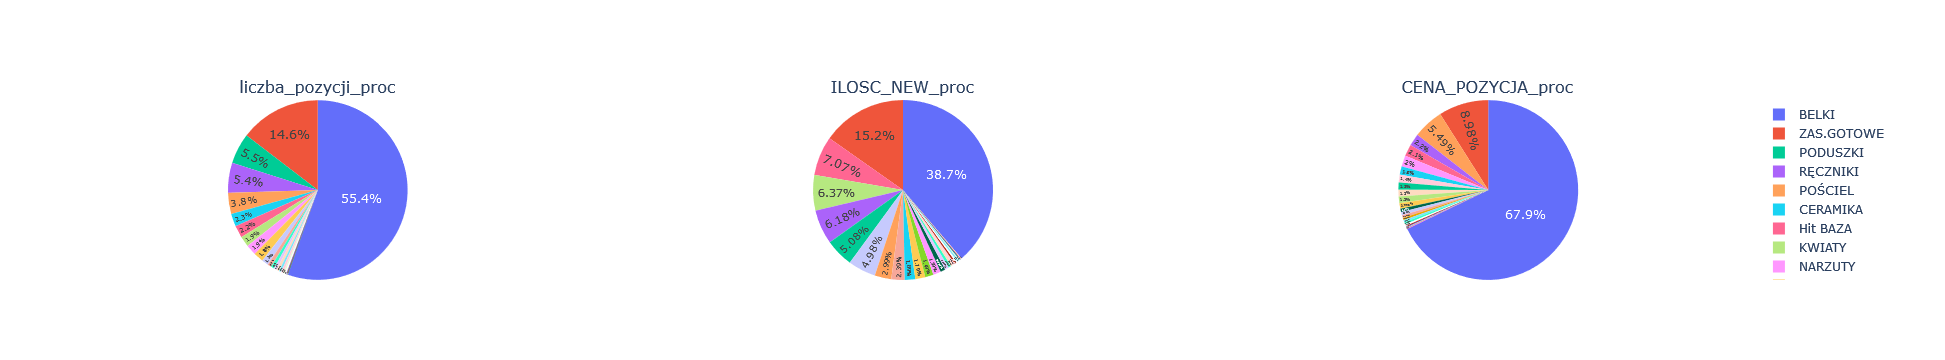

liczba_pozycji  ILOSC_NEW  CENA_POZYCJA  liczba_pozycji_proc  \
NAZWA_ZNACZNIK                                                                  
ROLETY                       57       59.0           0.0                  0.3   
PASM.SALON                    2        2.0           0.0                  0.0   
INNE                          3        3.0          16.6                  0.0   
DOD.KRAWIECKIE                3       46.0          25.5                  0.0   
MAT.NA POŚCIEL                3       14.6          32.2                  0.0   
WIELKANOC                    17       35.0          42.2                  0.1   
ŚWIECE                       10       12.0         101.2                  0.1   
PODKŁADKI                    94      178.0         108.7                  0.5   
TAŚMY                         3      400.0         112.2                  0.0   
CER.UŻYTKOWA                  4        6.0         118.6                  0.0   
HOTELE                       22       83.4         402.0                  0.1   
ART.DEKORACYJNE              36       74.0         510.4                  0.2   
KOŁDRY                        7        9.0         629.7                  0.0   
OBRAZY                       68       69.0         720.1                  0.4   
KOCE                        123      135.0         789.8                  0.6   
PASMANTERIA                 140      652.1         960.4                  0.7   
WKŁ+PODUSZ.                  23      233.0        1061.2                  0.1   
ŚWIĘTA                      226     1355.0        1090.6                  1.2   
OBRUSY                      342      478.0        1704.1                  1.8   
WYPOSAŻENIE                  88      100.0        2080.6                  0.5   
KWIATY                      355     1757.0        2093.3                  1.9   
PODUSZKI                   1055     1399.0        2360.6                  5.5   
LAMPY                        84       97.0        2426.1                  0.4   
CERAMIKA                    432      506.0        2664.6                  2.3   
NARZUTY                     364      376.0        3634.7                  1.9   
Hit BAZA                    426     1934.6        3724.6                  2.2   
RĘCZNIKI                   1044     1683.0        4031.6                  5.4   
POŚCIEL                     736      809.0        9813.9                  3.8   
ZAS.GOTOWE                 2791     4165.0       16049.8                 14.6   
BELKI                     10624    10624.0      121958.7                 55.4   

                 ILOSC_NEW_proc  CENA_POZYCJA_proc  
NAZWA_ZNACZNIK                                      
ROLETY                      0.2                0.0  
PASM.SALON                  0.0                0.0  
INNE                        0.0                0.0  
DOD.KRAWIECKIE              0.2                0.0  
MAT.NA POŚCIEL              0.1                0.0  
WIELKANOC                   0.1                0.0  
ŚWIECE                      0.0                0.1  
PODKŁADKI                   0.7                0.1  
TAŚMY                       1.5                0.1  
CER.UŻYTKOWA                0.0                0.1  
HOTELE                      0.3                0.2  
ART.DEKORACYJNE             0.3                0.3  
KOŁDRY                      0.0                0.4  
OBRAZY                      0.3                0.4  
KOCE                        0.5                0.4  
PASMANTERIA                 2.4                0.5  
WKŁ+PODUSZ.                 0.9                0.6  
ŚWIĘTA                      5.0                0.6  
OBRUSY                      1.8                1.0  
WYPOSAŻENIE                 0.4                1.2  
KWIATY                      6.4                1.2  
PODUSZKI                    5.1                1.3  
LAMPY                       0.4                1.4  
CERAMIKA                    1.9                1.5  
NARZUTY                     1.4               

In [50]:
func_big_view(df_szac, ['NAZWA_ZNACZNIK'],
             'nzapisz', 'plus_filia_00')
# func_big_view(df_fi.loc[df_fi['ANALIT01']!='00'], ['NAZWA_ZNACZNIK'],
#              'nzapisz', 'bez_filia_00')

In [14]:

func_big_view(df_fi, ['ANALIT01','NAZWA_ZNACZNIK'],
             'zapisz', 'plus_filia_00')
func_big_view(df_fi.loc[df_fi['ANALIT01']!='00'], ['ANALIT01','NAZWA_ZNACZNIK'],
             'zapisz', 'bez_filia_00')

## ploty na dostawce/znacznik

In [66]:
df_fi.groupby(['ANALIT02']).agg({'FAKTURA':'nunique'}).sort_values(by='FAKTURA', ascending=False).to_excel(path_to_catalog+'tabele_wyniki/unikatowe_dokumenty_z_FI.xlsx')

In [51]:
def func_plot_scatter(df, dict_agg, gr,
                     df_sell,
                     jaka_ilosc):
    df_sell=df_sell.loc[df_sell['ILOSC_SUM']>=1]
    if 'ANALIT01' in df.columns:
        df=df.loc[df['ANALIT01'].isin(['LI','FE', 'OU'])]
    # df_dostawca_produkt=df[['DOSTAWCA','KOD_TEMA']].drop_duplicates()
    df_gr_filtr=df[[gr]].drop_duplicates()
    df_gr=df.groupby(gr).agg(dict_agg).sort_values(by='CENA_POZYCJA', ascending=False).reset_index()
    # df_sell_dostawca_produkt=df_sell.merge(df_dostawca_produkt, how='inner', on=list(df_dostawca_produkt.columns)).\
    #                                 groupby(gr).agg({'WARTSB_SUM_BRUTTO_SALON':'sum'}).reset_index()
    df_sell=df_sell.merge(df_gr_filtr, how='inner', on=list(df_gr_filtr.columns)).\
                    groupby(gr).agg({'WARTSB_SUM_BRUTTO_SALON':'sum',
                                    'ILOSC_SUM':'sum'}).reset_index()
    df_gr=df_gr.merge(df_sell, how='inner', on=gr)
    df_gr['proc']=df_gr[jaka_ilosc]/df_gr['ILOSC_SUM']*100
    # df_gr.sort_values(by='proc').to_excel(path_to_catalog+'tabele_wyniki\\'+'tabela_do_wykresu_'+gr+'.xlsx')
    df_gr=round(df_gr,1)
    if gr=='NAZWA_ZNACZNIK':
        fig=px.scatter(df_gr.loc[df_gr['proc']<=100],
                  x=gr,
                  color=jaka_ilosc,
                   y='CENA_POZYCJA',
                   size='proc',
                   color_continuous_scale=["red", "green", "blue"],
                  #color='NAZWA_ZNACZNIK',
                  height=600,
                  hover_name=gr, 
                    #hover_data={"proc":'%{text:.2s}'},
                    text='CENA_POZYCJA',
                  size_max=60)#,
                  #log_y=True)
    else:
        fig=px.scatter(df_gr.loc[df_gr['proc']<=100],
                      x=gr,
                      color=jaka_ilosc,
                       y='CENA_POZYCJA',
                       #size='proc',
                       color_continuous_scale=["red", "green", "blue"],
                      #color='NAZWA_ZNACZNIK',
                      height=600,
                      hover_name=gr, hover_data=['proc'])
                      #size_max=60)#,
                      #log_y=True)
    fig.update_layout(hovermode="x")
    fig.update_traces(texttemplate='%{text:.2s}', textposition='top center')
    fig.show()
    
    _=df_gr[dict_agg.keys()]/df_gr[dict_agg.keys()].sum()*100
    _=_.rename(columns={jaka_ilosc:'ILOSC_PROCENT',
                        'CENA_POZYCJA':'CENA_POZYCJA_PROCENT'})
    _1=(df_gr[dict_agg.keys()]/df_gr[dict_agg.keys()].sum()*100).cumsum()
    _1=_1.rename(columns={jaka_ilosc:'ILOSC_PROCENT_NARASTAJACY',
                        'CENA_POZYCJA':'CENA_POZYCJA_PROCENT_NARASTAJACY'})
    # df_gr[[gr]].merge(_, how='left', left_index=True, right_index=True).merge(_1, how='left', left_index=True, right_index=True).\
    #     to_excel(path_to_catalog+'tabele_wyniki\\'+'tabela_do_wykresu_pareto_ilosc_'+gr+'.xlsx')
    
    fig.write_html(path_to_catalog+gr+'_wartosc_reklamacji'+'.html')
    return

In [26]:
df_fi.loc[df_fi['NAZWA_ZNACZNIK']=='ZAS.GOTOWE'].groupby(['ANALIT01','NAZWA_ZNACZNIK']).agg({'ILOSC':'sum'})

ILOSC
ANALIT01 NAZWA_ZNACZNIK         
         ZAS.GOTOWE         33.0
00       ZAS.GOTOWE      71540.0
FE       ZAS.GOTOWE        739.0
LI       ZAS.GOTOWE        762.0
OU       ZAS.GOTOWE       1881.0
SF       ZAS.GOTOWE          8.0
SW       ZAS.GOTOWE          4.0

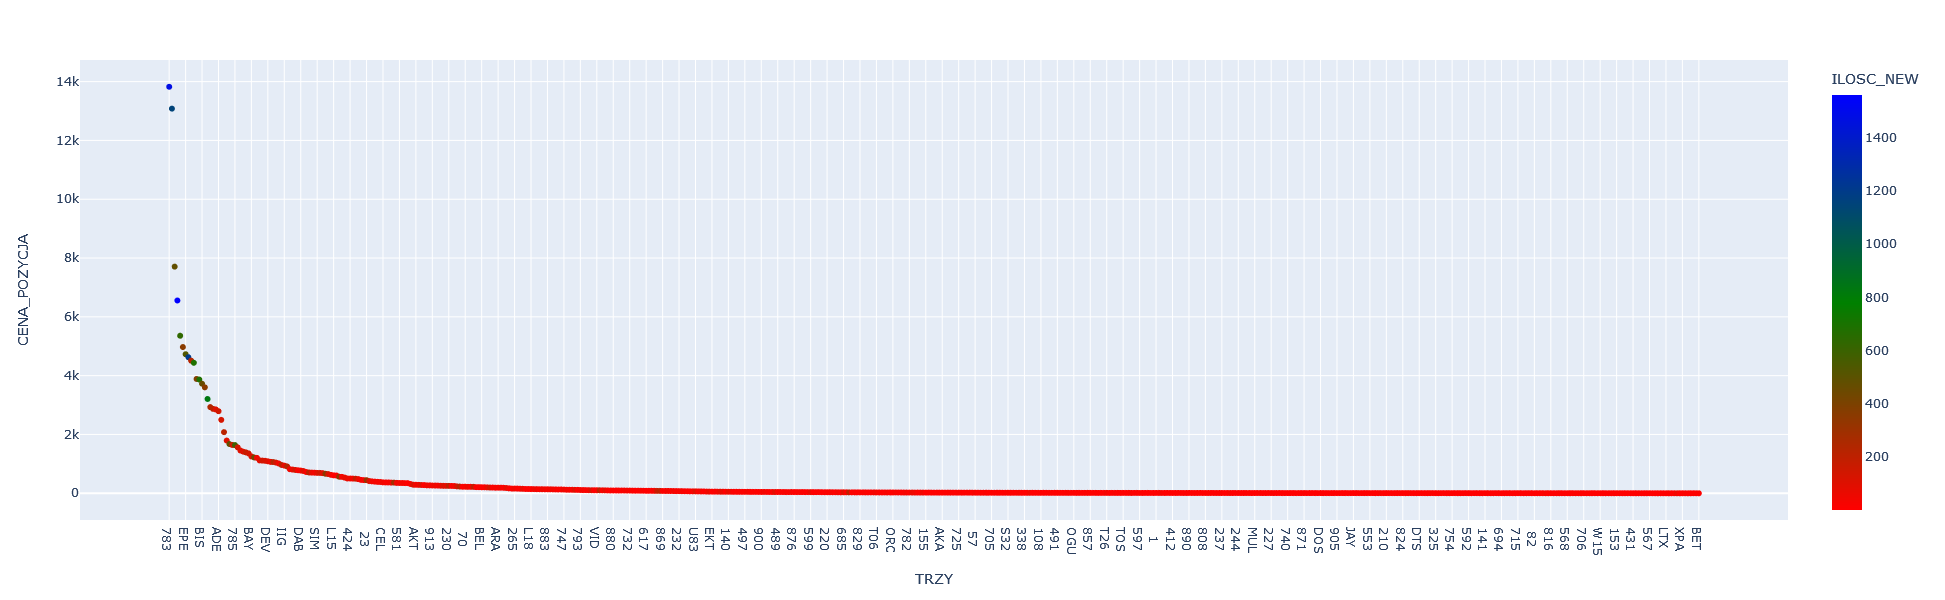

In [53]:
func_plot_scatter(df_szac, {'ILOSC_NEW':'sum',
                         'CENA_POZYCJA':'sum'},
                  'TRZY',
                 df_sell,
                 'ILOSC_NEW')

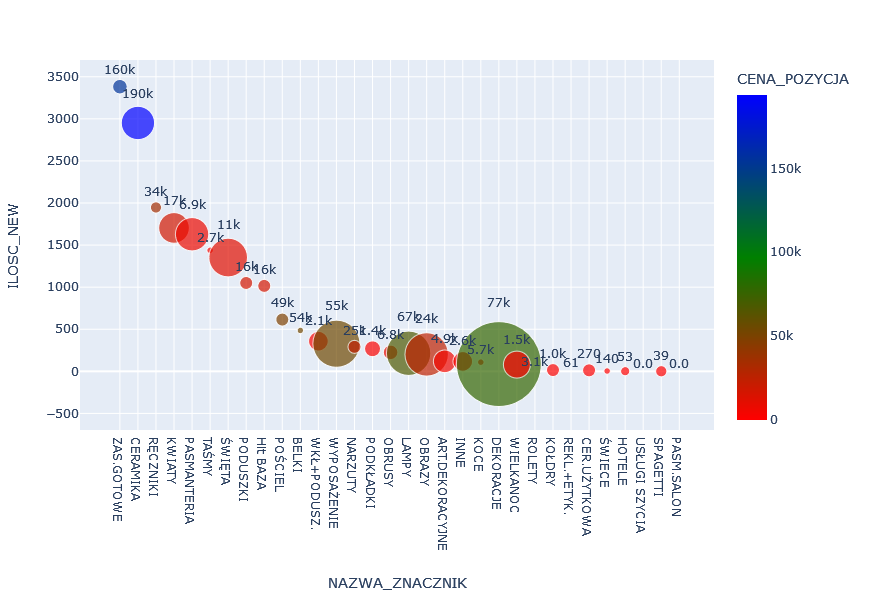

In [43]:
func_plot_scatter(df_fi, {'ILOSC_NEW':'sum',
                         'CENA_POZYCJA':'sum'}, 
                  'NAZWA_ZNACZNIK',
                 df_sell,
                 'ILOSC_NEW')

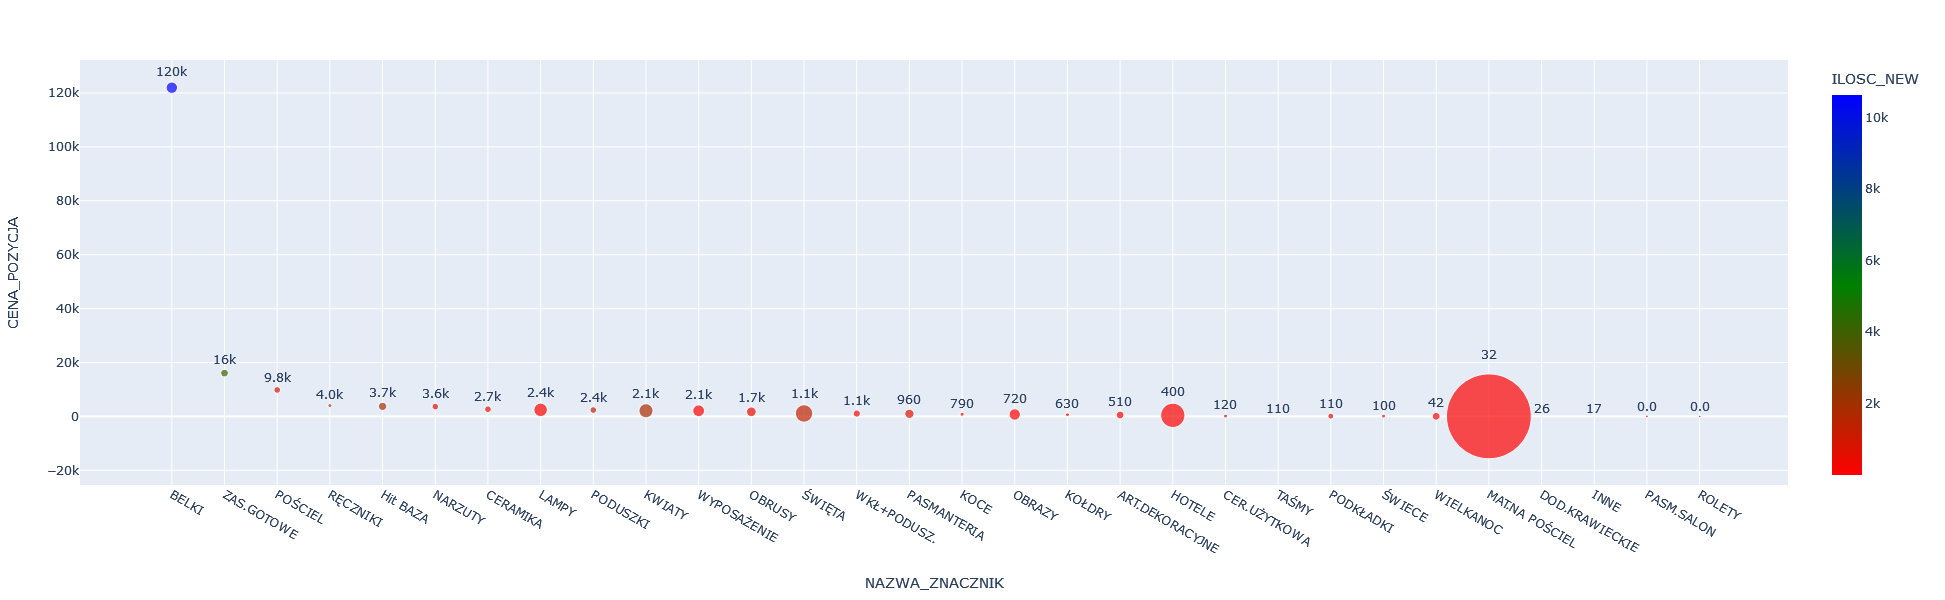

In [52]:
func_plot_scatter(df_szac, {'ILOSC_NEW':'sum',
                         'CENA_POZYCJA':'sum'}, 
                  'NAZWA_ZNACZNIK',
                 df_sell,
                 'ILOSC_NEW')

In [31]:
df_fi.groupby(['NAZWA_ZNACZNIK']).agg({'ILOSC':'sum',
                                      'CENA_POZYCJA':'sum',
                                      'FAKTURA':['count','nunique']}).sort_values(by=(       'ILOSC',     'sum'),
                                                                                 ascending=False)

ILOSC  CENA_POZYCJA FAKTURA        
                      sum           sum   count nunique
NAZWA_ZNACZNIK                                         
ZAS.GOTOWE       75269.00  4.832258e+06   25798   13121
ŚWIĘTA           18188.00  1.774523e+05    2576     408
PODUSZKI         13974.00  2.736027e+05    6023    1961
BELKI            12532.67  3.497766e+05    1327     595
RĘCZNIKI         10022.00  2.351767e+05    4391    1566
POŚCIEL           7629.20  8.076059e+05    5040    1950
TAŚMY             7294.00  1.915372e+04      64      49
CERAMIKA          5885.00  3.794656e+05    4488    1769
NARZUTY           5396.00  6.492777e+05    3794    1950
Hit BAZA          4289.25  7.945910e+04     363     211
KWIATY            3650.00  5.095447e+04     593     177
OBRUSY            3609.00  1.777755e+05    1943     602
PASMANTERIA       3006.39  2.889673e+04     584     181
KOCE              1913.00  1.480930e+05    1203     638
WKŁ+PODUSZ.       1682.00  1.060744e+04     166     117
PODKŁADKI         1338.00  9.889244e+03     330     193
WYPOSAŻENIE        796.00  1.729537e+05     572     437
OBRAZY             778.00  1.197735e+05     706     266
KARNISZE           669.00  9.685389e+02      21      10
LAMPY              583.00  2.021065e+05     477     325
DOD.KRAWIECKIE     560.00  9.643200e+02       9       7
ART.DEKORACYJNE    282.00  1.757168e+04     124      76
ROLETY             221.96  3.457173e+04     161      38
INNE               146.00  3.876148e+03      67      58
WIELKANOC          134.00  2.291650e+03      69      34
DEKORACJE          111.41  9.943373e+04      93      50
KOŁDRY             105.00  9.493866e+03      65      48
HOTELE              56.00  2.672692e+03      16       9
CER.UŻYTKOWA        21.00  3.002073e+03      17      12
ŚWIECE              21.00  9.532869e+02      13      10
REKL.+ETYK.         15.00  7.559580e+01       5       5
USŁUGI SZYCIA        4.00  4.052112e+02       3       3
ROL+PLISY            2.00  2.307480e+01       1       1
SPAGETTI             1.00  3.874500e+01       1       1
PASM.SALON           1.00  0.000000e+00       1       1

## ploty dla znacznikow po dostawcach

In [7]:
if 'sprzedaz_calego_dostawcy' in df_fi:
    pass
else:
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby('DOSTAWCA').agg(sprzedaz_calego_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_calego_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA'])
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby(['DOSTAWCA','NAZWA_ZNACZNIK']).agg(sprzedaz_znacznik_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_znacznik_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA','NAZWA_ZNACZNIK'])
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby(['DOSTAWCA','KOD_TEMA']).agg(sprzedaz_kod_tema_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_kod_tema_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA','KOD_TEMA'])

In [8]:
df_fi=df_fi.fillna(0)

In [9]:
df_fi_sell=df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].\
    groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK','RODZAJ','KOD_TEMA']).agg({'ILOSC':'sum',
                                                                               'CENA_POZYCJA':'sum',
                                                                               'Z_DNIA':'nunique',
                                                                               'sprzedaz_calego_dostawcy_ilosc':'first',
                                                                      'sprzedaz_znacznik_dostawcy_ilosc':'first',
                                                                      #'sprzedaz_kod_tema_dostawcy_ilosc':'first',
                                                                     'sprzedaz_calego_dostawcy':'first',
                                                                      'sprzedaz_znacznik_dostawcy':'first'}).reset_index().\
        groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'ILOSC':'sum',
                                                                               'CENA_POZYCJA':'sum',
                                                                               'Z_DNIA':'sum',
                                                                               'sprzedaz_calego_dostawcy_ilosc':'first',
                                                                      'sprzedaz_znacznik_dostawcy_ilosc':'first',
                                                                      #'sprzedaz_kod_tema_dostawcy_ilosc':'first',
                                                                     'sprzedaz_calego_dostawcy':'first',
                                                                      'sprzedaz_znacznik_dostawcy':'first'}).reset_index()

# df_fi_sell=df_fi_sell.merge(df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].\
#                                 groupby(['FAKTURA','ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'WARTOSC_B':'first'}).reset_index().\
#                                 groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'WARTOSC_B':'sum'}).reset_index(),
#                             how='left',
#                             on=['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK'])

In [10]:
from sklearn.cluster import KMeans

In [11]:
from sklearn.metrics import silhouette_score
def func_choose_k(x):
    sil = []
    kmax = 6
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    plt.plot(range(2, kmax+1), sil)
    plt.show()

    
def func_odwroc_pred(x, x_centers):
    if x_centers[0][1]>x_centers[1][1]:
        return x
    else:
        for i in range(0,len(x)):
            if x[i]==0:
                x[i]=1
            else:
                x[i]=0
        return x
    
    
def func_cluster(df, znacznik, gdzie, plot=1):
    if znacznik!='':
        df=df.loc[df['NAZWA_ZNACZNIK']==znacznik]
        df=df.loc[df['ANALIT02']==gdzie]
        df=df.loc[df['ILOSC']<=df['sprzedaz_calego_dostawcy_ilosc']]
        df['proc_reklamacji_do_znacznik_dostawca']=df['ILOSC']/df['sprzedaz_znacznik_dostawcy_ilosc']*100
        #display(df.sort_values(by='proc_reklamacji_do_znacznik_dostawca'))
        try:
            kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
            x_pred=kmeans.predict(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
            #print(kmeans.labels_, kmeans.cluster_centers_)
            x_pred=func_odwroc_pred(x_pred, kmeans.cluster_centers_)
            df['pred_cluster']=x_pred
            df['pred_cluster']=df['pred_cluster'].astype(str)
            if plot:
                fig=px.scatter(df,
                               x='ILOSC',
                               color='CENA_POZYCJA',
                               y='proc_reklamacji_do_znacznik_dostawca',
                              color_continuous_scale=["red", "green", "blue"])#px.colors.sequential.solar_r)
                fig.show()
                func_choose_k(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
                
            return df[['NAZWA_ZNACZNIK','ANALIT02', 'DOSTAWCA', 'pred_cluster']]
        except: return
    
    
    else:
        df=df.groupby(['ANALIT02','DOSTAWCA']).agg({'CENA_POZYCJA':'sum',
                                                    'ILOSC':'sum',
                                                       'Z_DNIA':'sum',
                                                       'sprzedaz_calego_dostawcy_ilosc':'first',
                                             'sprzedaz_calego_dostawcy':'first'}).reset_index()
        df=df.loc[df['ILOSC']<=df['sprzedaz_calego_dostawcy_ilosc']]
        df=df.loc[df['ANALIT02']==gdzie]
        df['proc_reklamacji_do_dostawca']=df['ILOSC']/df['sprzedaz_calego_dostawcy_ilosc']*100
        #display(df.corr())
        
        kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['ILOSC','proc_reklamacji_do_dostawca']])
        x_pred=kmeans.predict(df[['ILOSC','proc_reklamacji_do_dostawca']])
        df['pred_cluster']=x_pred
        df['pred_cluster']=df['pred_cluster'].astype(str)
        if plot:
            fig=px.scatter(df,
                           x='ILOSC',
                           color='CENA_POZYCJA',
                           #symbol='ANALIT02',
                           y='proc_reklamacji_do_dostawca',
                              color_continuous_scale=["red", "green", "blue"])
            fig.show()
        func_choose_k(df[['ILOSC','proc_reklamacji_do_dostawca']])
#         x_min, x_max = df['ILOSC'].min(),df['ILOSC'].max()
#         y_min, y_max = df['proc_reklamacji_do_dostawca'].min(),df['proc_reklamacji_do_dostawca'].max()
#         xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

#         # Obtain labels for each point in mesh. Use last trained model.
#         Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

#         # Put the result into a color plot
#         Z = Z.reshape(xx.shape)
#         plt.clf()
#         plt.imshow(
#             Z,
#             interpolation="nearest",
#             extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#             cmap=plt.cm.Paired,
#             aspect="auto",
#             origin="lower",
#         )
#         plt.scatter(x=df['ILOSC'],
#                    y=df['proc_reklamacji_do_dostawca'])
#         plt.scatter(x=kmeans.cluster_centers_[:,0],
#                     y=kmeans.cluster_centers_[:,1],
#                    color='green')
#         plt.show()

In [382]:
_=pd.DataFrame()
for i in df_fi_sell['NAZWA_ZNACZNIK'].unique():
    _=_.append(func_cluster(df_fi_sell, i, 'OUTLET', None))
    #break

In [356]:
_.pivot(index='DOSTAWCA',
       columns='NAZWA_ZNACZNIK',
       values='pred_cluster').to_excel(path_to_catalog+'usun_pivot_outlet.xlsx')

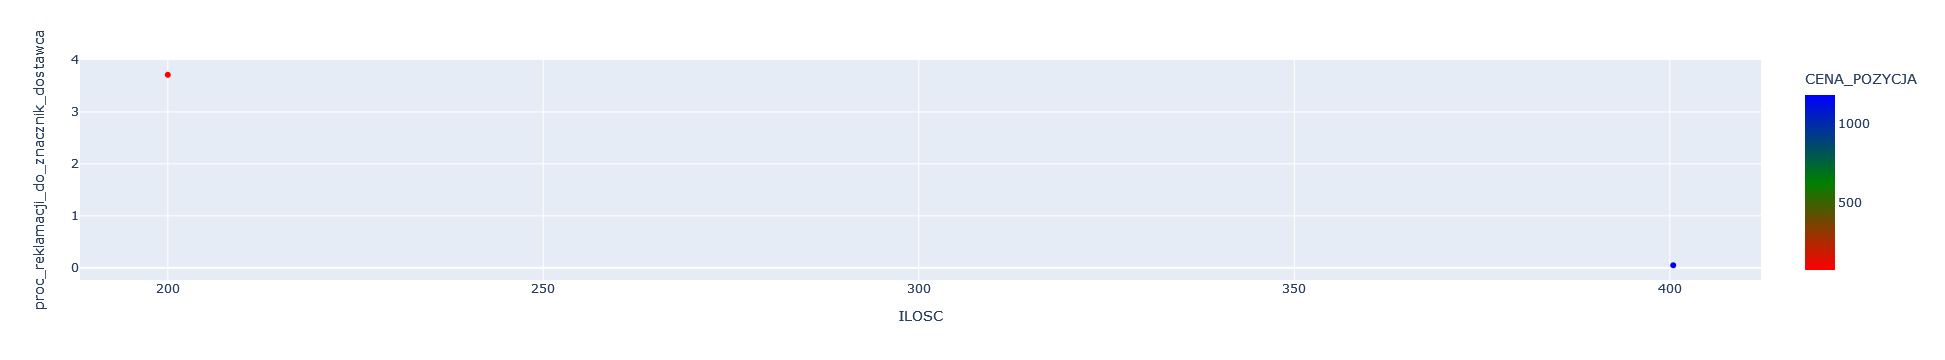

In [26]:
func_cluster(df_fi_sell, 'TAŚMY', 'OUTLET')

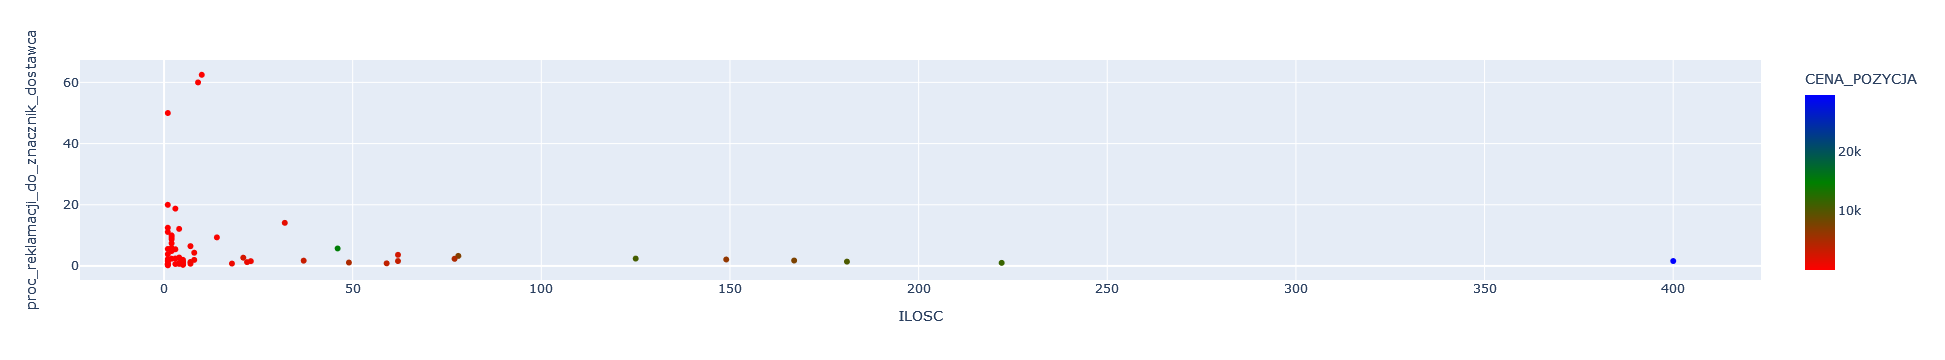

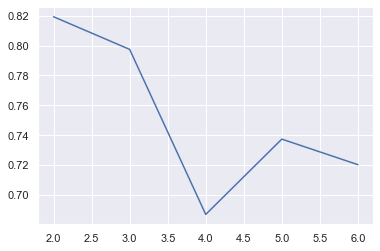

NAZWA_ZNACZNIK    ANALIT02 DOSTAWCA pred_cluster
312       CERAMIKA  LIKWIDACJA                     0
322       CERAMIKA  LIKWIDACJA     6788            0
355       CERAMIKA  LIKWIDACJA    10863            0
359       CERAMIKA  LIKWIDACJA    10872            0
360       CERAMIKA  LIKWIDACJA    10875            0
..             ...         ...      ...          ...
620       CERAMIKA  LIKWIDACJA   H76950            0
622       CERAMIKA  LIKWIDACJA   I16019            0
629       CERAMIKA  LIKWIDACJA   J24700            1
630       CERAMIKA  LIKWIDACJA   J25206            0
635       CERAMIKA  LIKWIDACJA   K68892            0

[61 rows x 4 columns]

In [46]:
func_cluster(df_fi_sell, 'CERAMIKA', 'LIKWIDACJA', 1)

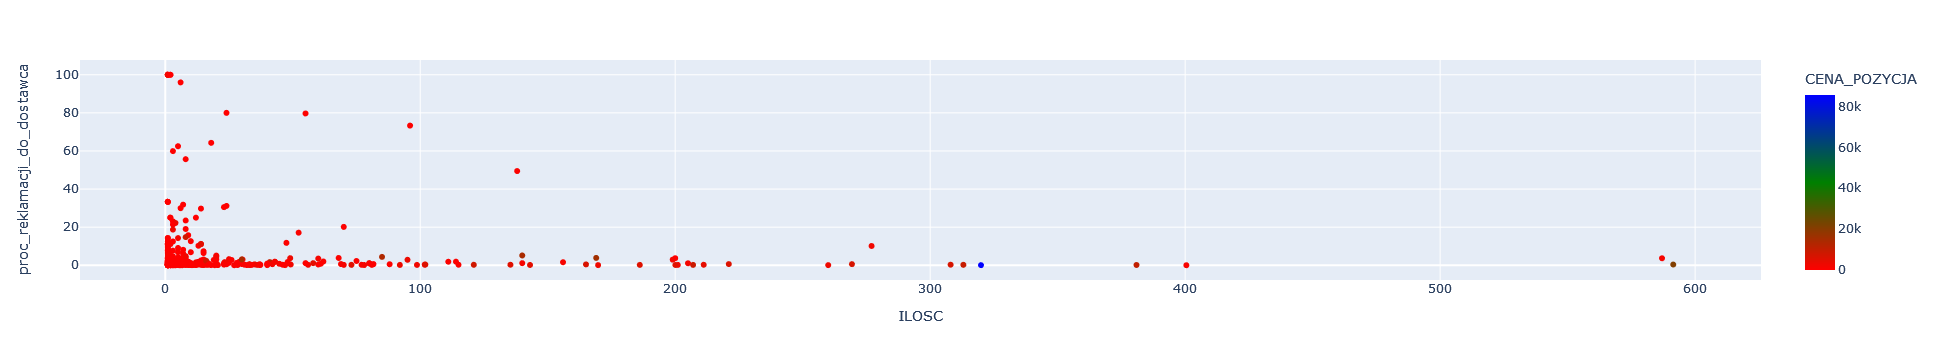

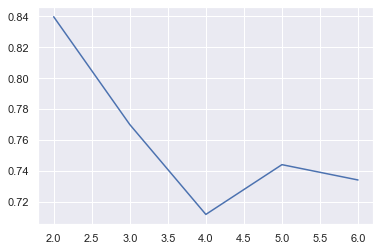

In [28]:
func_cluster(df_fi_sell, '', 'OUTLET',1)

In [33]:
df_sell.columns

Index(['FAKTURA_COUNT', 'DOKUMENT_COUNT', 'Z_DNIA', 'FILIA', 'KOD_TEMA',
       'TYP_DOK', 'JAK_POWST', 'WARTOB_SUM_NETTO_HURT',
       'WARTOBB_SUM_BRUTTO_HURT', 'WARTSN_SUM_NETTO_SALON',
       'WARTSB_SUM_BRUTTO_SALON', 'ILOSC_SUM', 'ZNACZNIK', 'DOSTAWCA', 'TRZY',
       'NAZWA_ZNACZNIK', 'year', 'month', 'day_of_year', 'week', 'week_day',
       'year_month', 'year_week', 'year_day', 'KOD', 'ANALIT01', 'ANALIT02',
       'ILOSC_NEW'],
      dtype='object')

In [65]:
def func_pary_dostawca_produkt(df, df_sell, czy_print):
    # ile jest wgl takich rodzajow zeby miały wiecej niz jednego dostawce?
    df_tmp=df.groupby(['NAZWA_ZNACZNIK','RODZAJ']).agg({'TRZY':'nunique'}).sort_values(by='TRZY')
    # display(df_tmp.loc[df_tmp['TRZY']>1])
    # display(df_tmp.loc[df_tmp['TRZY']==1])
    df_tmp=df_tmp.reset_index()
    
    
    df_sell=df_sell.rename(columns={'ILOSC_NEW':'ILOSC_NEW_SELL'})
    # df=df.groupby(['TRZY','RODZAJ','NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
    #                                                      'ILOSC_NEW':'sum'}).reset_index()
    df=df.merge(df_sell.groupby(['KOD_TEMA']).agg({'WARTSB_SUM_BRUTTO_SALON':'sum',
                                                 'ILOSC_NEW_SELL':'sum'}).reset_index(),
                how='left',
                on='KOD_TEMA')
                # on=['TRZY','RODZAJ','NAZWA_ZNACZNIK'])
    # display(df_tmp)
    # return
    df_tmp_oszczednosc_short=pd.DataFrame()
    flaga=0
    for i in tqdm(-np.sort(-df_tmp.loc[df_tmp['TRZY']>1].index)):
        try:
            rodzaj=df_tmp.loc[i, 'RODZAJ']#.values[0]
            nazwa_znacznik=df_tmp.loc[i, 'NAZWA_ZNACZNIK']#.values[0]
            
            df_tmp_wybrany=df.loc[df['RODZAJ']==rodzaj].loc[df['NAZWA_ZNACZNIK']==nazwa_znacznik].groupby('TRZY').agg({'CENA_POZYCJA':'sum',
                                                                                                                      'ILOSC_NEW':'sum',
                                                                                                                      'WARTSB_SUM_BRUTTO_SALON':'sum',
                                                                                                                         'ILOSC_NEW_SELL':'sum'}).\
                                                                                                    sort_values(by='CENA_POZYCJA', ascending=False).reset_index()
            df_tmp_wybrany['proc_wartosc']=df_tmp_wybrany['CENA_POZYCJA']/df_tmp_wybrany['WARTSB_SUM_BRUTTO_SALON']*100
            # df_tmp_wybrany=df_tmp_wybrany.merge(df_sell.loc[df_sell['RODZAJ']==rodzaj].loc[df_sell['NAZWA_ZNACZNIK']==nazwa_znacznik].\
            #                                             groupby('TRZY').agg(WARTSB_SUM_BRUTTO_SALON=('WARTSB_SUM_BRUTTO_SALON','sum'),
            #                                                                  ILOSC_NEW_SELL=('ILOSC_NEW','sum')).reset_index(),
            #                                    how='left',
            #                                    on='TRZY')
            
            df_tmp_wybrany=df_tmp_wybrany.loc[df_tmp_wybrany['proc_wartosc']<=100].sort_values(by='proc_wartosc', ascending=True).reset_index()
            if czy_print=='print':
                fig=px.scatter(df_tmp_wybrany,
                              x='proc_wartosc',
                              y='CENA_POZYCJA',
                              color='proc_wartosc',
                              color_continuous_scale=['red','green','blue'],
                               title=rodzaj+' - '+nazwa_znacznik+ ' - '+ str(df_tmp_wybrany['TRZY'].nunique()),
                          #size='ILOSC_NEW',
                              hover_data=['TRZY'],
                              log_y=True,
                              log_x=True)
            
                fig.show()
            
            
            
            flaga+=1
                       
            if df_tmp_wybrany['TRZY'].nunique()>13:
                range_for_choose_TRZY=range(2,11)
            elif df_tmp_wybrany['TRZY'].nunique()>4:
                range_for_choose_TRZY=range(2,5)
            else:
                range_for_choose_TRZY=range(1,2)
                
            for j in range_for_choose_TRZY:
                # if df_tmp_wybrany['TRZY'].nunique()==1:
                #     continue
                best_proc_mean=df_tmp_wybrany.iloc[:j]['CENA_POZYCJA'].sum()/df_tmp_wybrany.iloc[:j]['WARTSB_SUM_BRUTTO_SALON'].sum()*100
                #print(j, best_proc_mean)
                df_tmp_wybrany_do_zmiany=df_tmp_wybrany.iloc[j:]
                df_tmp_wybrany_do_zmiany['proc_wartosc_new']=best_proc_mean
                df_tmp_wybrany_do_zmiany['CENA_POZYCJA_new']=df_tmp_wybrany_do_zmiany['WARTSB_SUM_BRUTTO_SALON']*df_tmp_wybrany_do_zmiany['proc_wartosc_new']/100
                df_tmp_wybrany_do_zmiany['CENA_POZYCJA_oszczednosc']=df_tmp_wybrany_do_zmiany['CENA_POZYCJA']-df_tmp_wybrany_do_zmiany['CENA_POZYCJA_new']
                df_tmp_wybrany_do_zmiany['CENA_POZYCJA_oszczednosc_procent']=df_tmp_wybrany_do_zmiany['CENA_POZYCJA_oszczednosc']/df_tmp_wybrany_do_zmiany['CENA_POZYCJA_oszczednosc'].sum()*100
                #display(df_tmp_wybrany_do_zmiany)
                df_tmp_oszczednosc_short=df_tmp_oszczednosc_short.append({'NAZWA_ZNACZNIK':nazwa_znacznik,
                                                                          'RODZAJ':rodzaj,
                                                                        'ilu_dostawcow_benchmark':j,
                                                                         'ilu_dostawcow_wyliczenia':df_tmp_wybrany_do_zmiany['TRZY'].nunique(),
                                                                         'sredni_poziom_reklamacji':best_proc_mean,
                                                                         'oszczednosc_suma':df_tmp_wybrany_do_zmiany['CENA_POZYCJA_oszczednosc'].sum(),
                                                                         'procent_oszczednosci_w_reklamacjach':df_tmp_wybrany_do_zmiany['CENA_POZYCJA_oszczednosc'].sum()/df_tmp_wybrany['CENA_POZYCJA'].sum()*100},
                                                                         ignore_index=True)
                if czy_print=='print':
                    print(j, round(best_proc_mean, 2), 
                          f"{df_tmp_wybrany_do_zmiany['CENA_POZYCJA_oszczednosc'].sum():,.3f}",
                         round(df_tmp_wybrany_do_zmiany['CENA_POZYCJA_oszczednosc'].sum()/df_tmp_wybrany['CENA_POZYCJA'].sum()*100,1))
            if czy_print=='print':
                display(df_tmp_wybrany_do_zmiany.sort_values(by='CENA_POZYCJA_oszczednosc', ascending=False))
        except: continue
        
        #print(flaga)
        if flaga==1: break
    return df_tmp_oszczednosc_short.loc[df_tmp_oszczednosc_short['ilu_dostawcow_wyliczenia']>0].reset_index().drop('index', axis=1)

  0%|                                                                                          | 0/237 [00:00<?, ?it/s]

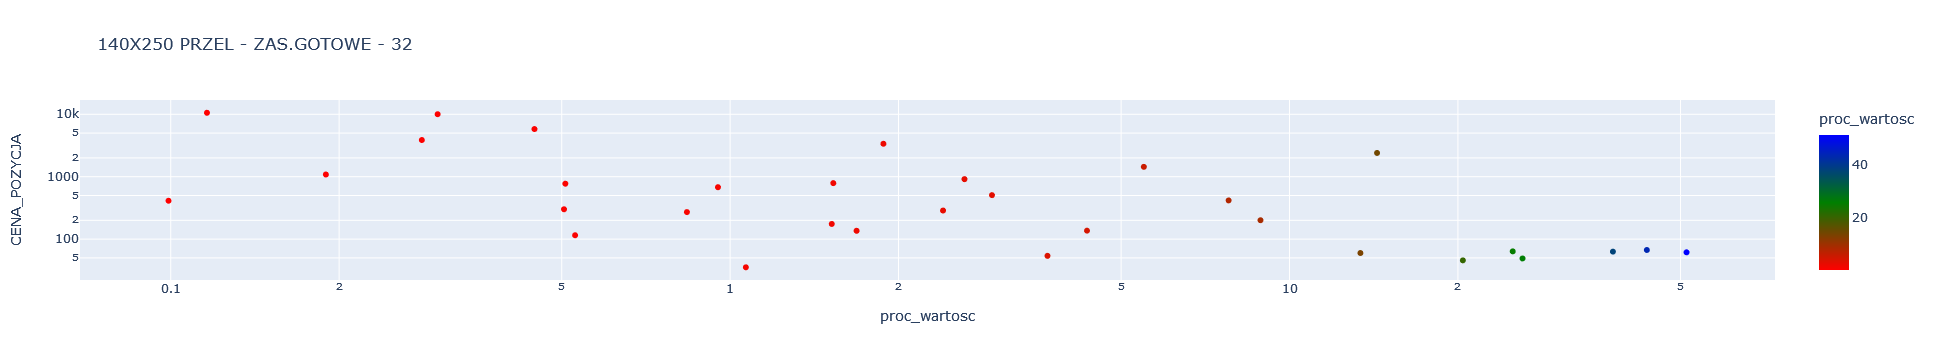

2 0.12 25,787.264 57.0
3 0.12 25,079.904 55.5
4 0.14 21,814.457 48.3
5 0.18 15,695.153 34.7
6 0.2 12,014.365 26.6
7 0.2 11,823.538 26.2
8 0.2 11,338.038 25.1
9 0.2 11,264.464 24.9
10 0.2 11,052.862 24.4


index TRZY  CENA_POZYCJA  ILOSC_NEW  WARTSB_SUM_BRUTTO_SALON  \
15      4  381     3371.6391       57.0            179421.404072   
25      5  HAR     2402.1162       47.0             16751.518259   
21      6  699     1440.4640       36.0             26237.232027   
17      8  885      915.5136       18.0             34893.766820   
13      9  656      789.3525       26.0             51626.617363   
10     11  851      679.0830       10.0             71402.237623   
18     12  892      506.6370       14.0             17244.757043   
22     13  869      417.2406        6.0              5361.766469   
16     17  745      287.3895        7.0             11964.708831   
23     19  528      201.2895        3.0              2268.580000   
12     20  KAR      175.1520        4.0             11529.100955   
20     22  747      136.7391        6.0              3147.360000   
14     23   99      136.0257        4.0              8083.140000   
30     28  831       67.0350        2.0               154.000000   
27     29  740       63.7140        3.0               254.250000   
29     30  147       63.0498        3.0               166.580000   
31     31  732       61.5000        2.0               120.000000   
24     32  531       59.8764        1.0               447.240000   
19     33  840       53.9970        1.0              1462.530000   
28     34  824       49.0770        1.0               188.100000   
26     36  907       45.6699        1.0               223.740000   
11     37  865       35.4117        1.0              3319.160000   

    ILOSC_NEW_SELL  proc_wartosc  proc_wartosc_new  CENA_POZYCJA_new  \
15          2664.0      1.879173          0.202818        363.898688   
25           174.0     14.339692          0.202818         33.975074   
21           539.0      5.490152          0.202818         53.213798   
17           498.0      2.623717          0.202818         70.770798   
13          1226.0      1.528964          0.202818        104.708011   
10          1085.0      0.951067          0.202818        144.816505   
18           396.0      2.937919          0.202818         34.975451   
22            47.0      7.781775          0.202818         10.874621   
16           170.0      2.401977          0.202818         24.266569   
23            37.0      8.872929          0.202818          4.601086   
12           200.0      1.519216          0.202818         23.383078   
20            77.0      4.344565          0.202818          6.383409   
14           117.0      1.682832          0.202818         16.394053   
30             4.0     43.529221          0.202818          0.312340   
27            19.0     25.059587          0.202818          0.515664   
29             6.0     37.849562          0.202818          0.337854   
31             4.0     51.250000          0.202818          0.243381   
24             6.0     13.387980          0.202818          0.907083   
19            32.0      3.692027          0.202818          2.966272   
28             3.0     26.090909          0.202818          0.381500   
26             5.0     20.412041          0.202818          0.453785   
11            88.0      1.066887          0.202818          6.731850   

    CENA_POZYCJA_oszczednosc  CENA_POZYCJA_oszczednosc_procent  
15               3007.740412                         27.212323  
25               2368.141126                         21.425593  
21               1387.250202                         12.551050  
17                844.742802                          7.642752  
13                684.644489                          6.194274  
10                534.266495                          4.833739  
18                471.661549                          4.267325  
22                406.365979                          3.676568  
16                263.122931                          2.380586  
23                196.688414                          1.779525  
12                151.768922                          1.373119  
20

  0%|                                                                                          | 0/237 [00:01<?, ?it/s]


In [66]:
df_tmp_oszczednosc_short=func_pary_dostawca_produkt(df_fi.loc[df_fi['ANALIT01'].isin(['LI','OU','FE'])],
                                                  df_sell,
                                                  'print')#

  0%|                                                                                          | 0/237 [00:00<?, ?it/s]

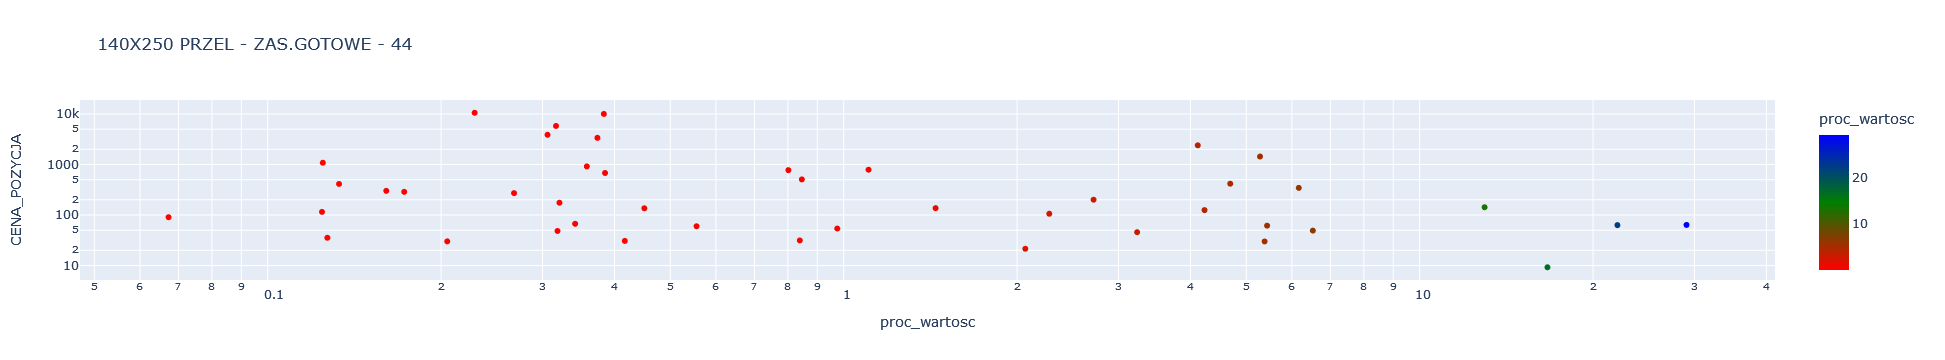

2 0.09 33,464.719 72.4
3 0.12 29,652.685 64.2
4 0.12 29,620.034 64.1
5 0.12 29,158.347 63.1
6 0.13 28,515.322 61.7
7 0.13 27,900.443 60.4
8 0.13 27,814.586 60.2
9 0.2 17,874.922 38.7
10 0.2 17,729.462 38.4


index TRZY  CENA_POZYCJA  ILOSC_NEW  WARTSB_SUM_BRUTTO_SALON  \
17      1  834    10035.9139      253.0             2.618441e+06   
32      5  HAR     2402.1162       47.0             5.833334e+04   
11      2  539     5799.4500      138.0             1.831830e+06   
16      4  381     3371.6391       57.0             9.026190e+05   
35      6  699     1440.4640       36.0             2.727249e+04   
10      3  350     3874.5369      102.0             1.265985e+06   
26      9  656      789.3525       26.0             7.147549e+04   
22     10  606      773.0673       10.0             9.645224e+04   
34     13  869      417.2406        6.0             8.899003e+03   
15      8  885      915.5136       18.0             2.556960e+05   
24     12  892      506.6370       14.0             5.990040e+04   
38     15  882      344.4000        8.0             5.584570e+03   
18     11  851      679.0830       10.0             1.763079e+05   
30     19  528      201.2895        3.0             7.412930e+03   
40     21  538      142.4463        1.0             1.098970e+03   
33     24  761      125.0541        5.0             2.955970e+03   
27     22  747      136.7391        6.0             9.471800e+03   
29     26  624      105.9768        2.0             4.659599e+03   
20     23   99      136.0257        4.0             3.018792e+04   
13     20  KAR      175.1520        4.0             5.457772e+04   
43     29  740       63.7140        3.0             2.192500e+02   
42     30  147       63.0498        3.0             2.859800e+02   
37     31  732       61.5000        2.0             1.131920e+03   
39     34  824       49.0770        1.0             7.523300e+02   
31     36  907       45.6699        1.0             1.413370e+03   
25     33  840       53.9970        1.0             5.541210e+03   
21     32  531       59.8764        1.0             1.078518e+04   
36     41  565       29.9505        1.0             5.567600e+02   
14     28  831       67.0350        2.0             1.961775e+04   
23     38  870       31.3650        1.0             3.738470e+03   
28     42  497       21.4635        1.0             1.038450e+03   
12     35  789       48.3390        2.0             1.517797e+04   
19     39  137       30.6885        1.0             7.363180e+03   
41     43  707        9.2250        1.0             5.535000e+01   

    ILOSC_NEW_SELL  proc_wartosc  proc_wartosc_new  CENA_POZYCJA_new  \
17    58608.307692      0.383278          0.202169       5293.676074   
32      692.000000      4.117913          0.202169        117.931942   
11    38193.000000      0.316593          0.202169       3703.393193   
16    13994.000000      0.373540          0.202169       1824.815941   
35      521.000000      5.281747          0.202169         55.136526   
10    31614.000000      0.306049          0.202169       2559.429436   
26     1728.000000      1.104368          0.202169        144.501285   
22     1042.000000      0.801503          0.202169        194.996535   
34       97.000000      4.688622          0.202169         17.991027   
15     3687.000000      0.358048          0.202169        516.938032   
24     1391.000000      0.845799          0.202169        121.100050   
38       54.000000      6.166992          0.202169         11.290270   
18     2586.000000      0.385169          0.202169        356.439906   
30      112.000000      2.715384          0.202169         14.986648   
40       16.000000     12.961801          0.202169          2.221777   
33       65.000000      4.230561          0.202169          5.976055   
27      213.000000      1.443644          0.202169         19.149045   
29       67.000000      2.274376          0.202169          9.420266   
20      622.000000      0.450596          0.202169         61.030621   
13     1038.000000      0.320922          0.202169        110.339242   
43       18.000000     29.059977          0.202169          0.443256   
42       15.000000     22.046926       

  0%|                                                                                          | 0/237 [00:01<?, ?it/s]


In [64]:
df_tmp_oszczednosc_short=func_pary_dostawca_produkt(df_fi.loc[df_fi['ANALIT01'].isin(['LI','OU','FE'])],
                                                  df_sell,
                                                  'print')#

In [79]:
df_tmp_oszczednosc_short.to_excel(path_to_catalog+'tabele_wyniki/df_tmp_oszczednosc_short_procent_oszczednosci_benchmark.xlsx')#.loc[df_tmp_oszczednosc_short['NAZWA_ZNACZNIK']=='BELKI']

## sprzedaz outlet vs wyslanie towarow na outlet z f56

roznica w cenach miedzy sprzedaza detaliczna a sprzedaza w outlecie

In [89]:
def func_procentowa_roznica_cen(df, group, save,
                               df_fi):
    df_total=df.loc[~df['ANALIT01'].isin(['OU','FE'])].groupby(group).agg({'WARTSB_SUM_BRUTTO_SALON':'sum',
                                                                                     'ILOSC_SUM':'sum'})
    df_ou=df.loc[df['ANALIT01']=='OU'].groupby(group).agg({'WARTSB_SUM_BRUTTO_SALON':'sum',
                                                                                     'ILOSC_SUM':'sum'})
    df_total['sr_cena_brutto_salon_total']=df_total['WARTSB_SUM_BRUTTO_SALON']/df_total['ILOSC_SUM']
    df_ou['sr_cena_brutto_salon_ou']=df_ou['WARTSB_SUM_BRUTTO_SALON']/df_ou['ILOSC_SUM']
    df_total=df_total.reset_index()
    df_ou=df_ou.reset_index()
    df_total=df_total.rename(columns={'WARTSB_SUM_BRUTTO_SALON':'WARTSB_SUM_BRUTTO_SALON_POZA_OUTLET'})
    df_ou=df_ou.rename(columns={'WARTSB_SUM_BRUTTO_SALON':'WARTSB_SUM_BRUTTO_SALON_OUTLET'})
    df=df_ou[group+['sr_cena_brutto_salon_ou', 'WARTSB_SUM_BRUTTO_SALON_OUTLET']].merge(df_total[group+['sr_cena_brutto_salon_total', 'WARTSB_SUM_BRUTTO_SALON_POZA_OUTLET']],
                                                                                       how='outer',
                                                                                       on=group)
    df['jaka_roznica_procentowa']=round((df['sr_cena_brutto_salon_ou']-df['sr_cena_brutto_salon_total'])/df['sr_cena_brutto_salon_total']*100, 1)
    df=df.loc[df['jaka_roznica_procentowa'].notnull()].sort_values(by='jaka_roznica_procentowa')
    
    df_fi=df_fi.loc[df_fi['ANALIT01']!='00'].groupby(group).agg(CENA_POZYCJA_wartosc_reklamacji=('CENA_POZYCJA','sum')).reset_index()
    df=df.merge(df_fi,
               how='outer',
               on=group)
    
    if save=='zapisz':
        if 'KOD_TEMA' in group:
            func_slownik_nazwa_rodzaj(df).to_excel(path_to_catalog+'tabele_wyniki\procentowa_roznica_cen_'+'_'.join(group)+'.xlsx')
        else:
            df.to_excel(path_to_catalog+'tabele_wyniki\procentowa_roznica_cen_'+'_'.join(group)+'.xlsx')
    else:
        display(df.loc[df['jaka_roznica_procentowa'].notnull()].sort_values(by='jaka_roznica_procentowa'))

In [92]:
func_procentowa_roznica_cen(df_sell, ['NAZWA_ZNACZNIK','KOD_TEMA'],
                           'zapisz',
                           df_fi)

In [93]:
func_procentowa_roznica_cen(df_sell, ['NAZWA_ZNACZNIK'],
                           'nzapisz',
                           df_fi)

NAZWA_ZNACZNIK  sr_cena_brutto_salon_ou  WARTSB_SUM_BRUTTO_SALON_OUTLET  \
0       WYPOSAŻENIE                27.566320                     9289.850000   
1              INNE                 4.183958                      348.105325   
2     USŁUGI MONTAŻ                 1.927771                       15.422171   
3       REKL.+ETYK.                 0.579931                     1357.619185   
4             BELKI                 9.769635                   125967.630952   
5   ART.DEKORACYJNE                11.312199                     4886.870000   
6       PASMANTERIA                 2.343656                     5099.912962   
7        PASM.SALON                 3.192555                      340.549801   
8         DEKORACJE               146.023810                     6133.000000   
9            ŚWIĘTA                 3.291516                     5470.500000   
10           ŚWIECE                11.980769                      311.500000   
11            LAMPY               164.654472                    20252.500000   
12    USŁUGI SZYCIA                 4.224475                    17235.877089   
13      USŁUGI INNE                 3.643500                       18.217500   
14       ZAS.GOTOWE                22.121885                    78458.582148   
15         SPAGETTI                 5.909091                      390.000000   
16      WKŁ+PODUSZ.                 6.391285                     5272.810000   
17   DOD.KRAWIECKIE                 1.322956                     1528.696603   
18         KARNISZE                 2.172644                      189.020000   
19           OBRAZY                75.376099                    13718.450000   
20           HOTELE                25.285714                      442.500000   
21           KWIATY                 7.712969                    35016.880000   
22    USŁUGI ROLETY                46.864701                     2716.278051   
23         PODUSZKI                11.380295                    30908.880000   
24         CERAMIKA                26.718032                    67489.750000   
25          NARZUTY                55.000373                    44275.300000   
26           OBRUSY                28.278778                    18975.060000   
27         Hit BAZA                12.917566                    16336.630002   
28        PODKŁADKI                 4.329368                     4112.900000   
29             KOCE                32.085369                    23069.380000   
30           KOŁDRY               116.916667                     2455.250000   
31          POŚCIEL                68.930662                    66655.950026   
32        WIELKANOC                13.245426                     2490.140000   
33     CER.UŻYTKOWA                13.906949                     8705.750000   
34           ROLETY                22.564641                     1972.149666   
35         RĘCZNIKI                18.032456                   164978.940000   
36            TAŚMY                 2.071029                    16905.128520   
37          GERLACH               124.050000                      248.100000   

    sr_cena_brutto_salon_total  WARTSB_SUM_BRUTTO_SALON_POZA_OUTLET  \
0                   160.851959                         9.655943e+05   
1                    24.045996                         3.035885e+05   
2                    10.646975                         9.549549e+05   
3                     3.189482                         1.374594e+05   
4                    45.051204                         3.075267e+07   
5                    50.565745                         4.928646e+05   
6                    10.022886                         6.141004e+05   
7                    10.620407                         2.934770e+04   
8                   475.406719                         2.258657e+05   
9                     9.894284                         3.690905e+05   
10                   32.931172                         2.091140e+05   
11                  438.504117  

In [102]:
df_fi.loc[df_fi['NAZWA_ZNACZNIK']=='DEKORACJE'].groupby(['RODZAJ','NAZWA']).agg({'CENA_POZYCJA':'sum'}).sort_values(by='CENA_POZYCJA').tail(50)

CENA_POZYCJA
RODZAJ               NAZWA                         
TWO  Z9021/036027    Dekoracja STAROS    293.305800
WITRYNA 73           DEKORACJA           299.295900
                     PRÓBNIK FLEX        328.742100
t Stoma Z9021/089399 Dekoracja Gabine    350.094900
        Z9021/027039 POPRAWKA P.WIĘCH    363.108300
KA   ZC522/029143    Dekoracja SIELAN    389.700900
        Z9021/077325 Dekoracja ŁAPETA    389.934600
WITRYNA 14           DEKORACJA           416.957700
    140X200 70X80/X2 MS/POS/ST/ADA       423.415200
ROWK Z9022/005699    Dekoracja SZTAJE    427.412700
                     DEK.NR.III SFERA    492.774900
A   ZQM20/059953     Dekoracja OKIENN    504.300000
                     DEK.NR.I SFERA      530.609700
                     DEK.NR.IX SFERA     535.874100
ZEWS Z9022/018777    Dekoracja MARCIS    542.110200
AK   Z9021/037653    Dekoracja BARTEL    566.538000
9 ROLETA             DEK.NR 14 06/201    600.350700
RANY Z9022/003323    Dekoracja EUROFI    640.005900
SKI  Z9021/094399    Dekoracja GŁOGOW    696.881100
     Z9021/074625    Dekoracja TLAŁKA    708.885900
J.ZIEZ9021/094483    ZASŁONY VEL/ITA/    828.847800
WITRYNA 6            DEKORACJA           830.471400
 popr.21/081489      Dekoracja Habdas    871.479600
ZY/15680/VELVET/J.K+ DEKORACJA           968.403600
     Z9022/037261    Dekoracja FLOREK    992.523900
                     POPRAWA P.KÓSKI    1139.890200
LEX            R64/3 FIRANA 250X273 F   1142.251800
SZT.                 VELVET GRAFIT 2    1309.445700
FLEX    Z9021/074632 ZASŁONA 215X262    1437.205800
N L84/1              DEK.WITRYNA EKRA   1441.043400
     Z9021/071114    Dekoracja PALUCH   1479.173400
AN REKLAMY           POKÓJ GLAMOUR-PL   1595.862393
ZIŃS Z9021/053335    Dekoracja GROMAD   1639.208700
KA E Z9021/063619    Dekoracja JASIŃS   1684.079100
JANK ZS9017/19403    Dekoracja SALON    1765.665000
WITRYNA 39           DEKORACJA          1889.169300
ETA/PO+RÓŻ FILE/SIAT DEK.NR 4 MYSORE/   2188.551300
ek      Z9022/039677 Dekoracja Cichop   2396.974800
ZY/13743/63006/ETA/B DEKORACJA          2453.604000
R/ZASŁONA            DEK.POKÓJ GLAMOU   2470.996200
OWAK Z9021/033266    Dekoracja NOWAKN   2538.510900
JANKI ZS9018/46561   Dekoracja SALON    2757.327900
H    Z9022/037336    Dekoracja MACIOC   2922.689100
ONA L174/2 PC/CEKIN  DEK.WITRYNA ZASŁ   3056.254800
0                    DEK. NR 9 02/202   3717.994800
 357003/POP+54878/B  DEK.NR16/VI/2018   3792.176100
JANK ZS9018/60667    Dekoracja SALON    4718.575200
ZY/12396/63006/NATU  DEKORACJA          6594.694200
NR.17 VEL/PUD+913327 DEK.TARGI 09/17    7380.356700
SALONY               DEKORACJA         15662.328000

In [101]:
df_fi.loc[df_fi['NAZWA_ZNACZNIK']=='ŚWIĘTA'].groupby(['RODZAJ','NAZWA']).agg({'CENA_POZYCJA':'sum'}).sort_values(by='CENA_POZYCJA').tail(50)

CENA_POZYCJA
RODZAJ            NAZWA                         
14X13CM  BORD     SW/OZD/HART/02        738.0000
10CM B+SREB       SW/B/STR/36B          745.2324
1 (X12)           SW/G/BETTY/SZAMP      745.2570
35X140 NATU       CHO/LIVVI/1/ŚW        745.8474
10CM ZŁOT         SW/B/SZ/133B          750.1278
10CM CZER         SW/B/SZ/136A          750.7920
10CM BIAŁ         SW/B/SZ/147A          769.2420
8CM ZŁOT          SW/B/SZ/145B          777.3600
80CM SZAM         SW/G/24/SZAM          781.1730
20CM BORD         SW/KW/64A             785.2320
10CM CZER         SW/B/SZ/148A          795.3180
43CM SREB         SW/G/46B              795.5640
8CM CZER          SW/B/SZ/142           796.7940
8CM BIAŁ          SW/B/SZ/139B          811.4310
19CM              SW/LAL/MELI/1/B       811.4925
35X180 NATU       CHO/LIVVI/1/ŚW        815.4900
10CM BIAŁ         SW/B/SZ/138B          821.3940
20CM SREB         SW/KW/54C             823.2390
300CM/360LED      SW/LAMP/G/360/B2      825.8220
8CM BIAŁ          SW/B/SZ/145A          825.9450
16CM ZŁOT         SW/KW/57C             832.4640
10CM SZAM         SW/B/SZ/147B          834.4320
10CM ZŁOT         SW/B/SZ/153B          886.5840
32CM SZAM         SW/KW/52C             896.6700
10CM SRE          SW/B/SZ/150C          918.0843
20CM RÓŻO         SW/KW/42/B            925.4520
80CM SREB         SW/G/24/SREB          936.6450
10CM CZER         SW/B/SZ/138D          938.7360
10CM BIAŁ         SW/B/SZ/148B          951.7740
8CM CZER          SW/B/SZ/143           977.8500
68CM B            SW/G/25/B            1028.3661
10X16 TURK        SW/G/34/TURK         1047.9600
73CM SREB         SW/G/28/SREB         1057.9230
10CM CZER         SW/B/SZ/144          1069.1160
30CM GRAN         SW/OZD/PTAK/14B      1074.5280
CHOINKA/PIEŃ/220C SW/EKSPOZYCJA        1107.0000
10CM CZER         SW/B/SZ/139A         1152.7560
                  SW/B/SZ/150B         1166.4090
10CM BIAŁ         SW/B/SZ/151A         1174.0104
10CM SREB         SW/B/SZ/147C         1199.4960
INT/GH31/220      SW/EKSP.CHOINKA      1353.0000
18CM   CZER+B     SW/KW/SUZI1/CZER     1366.4070
INT/GH09/220      SW/EKSP.CHOINKA      1608.8400
75CM SREB         SW/G/22/SREB         1673.7840
CHOINKA/ŚNIEŻ/220 SW/EKSPOZYCJA        2023.3500
210CM     B+ZIEL  SW/CHOINKA/01        2083.6200
500CM/200LED B    SW/LAMP/200LED/B     2178.8220
CHOINKA/220CM     SW/EKSPOZYCJA        3509.9034
CHOINKA/180CM     SW/EKSPOZYCJA        3616.2000
1000CM/400LED B   SW/LAMP/400LED/B     3943.6875

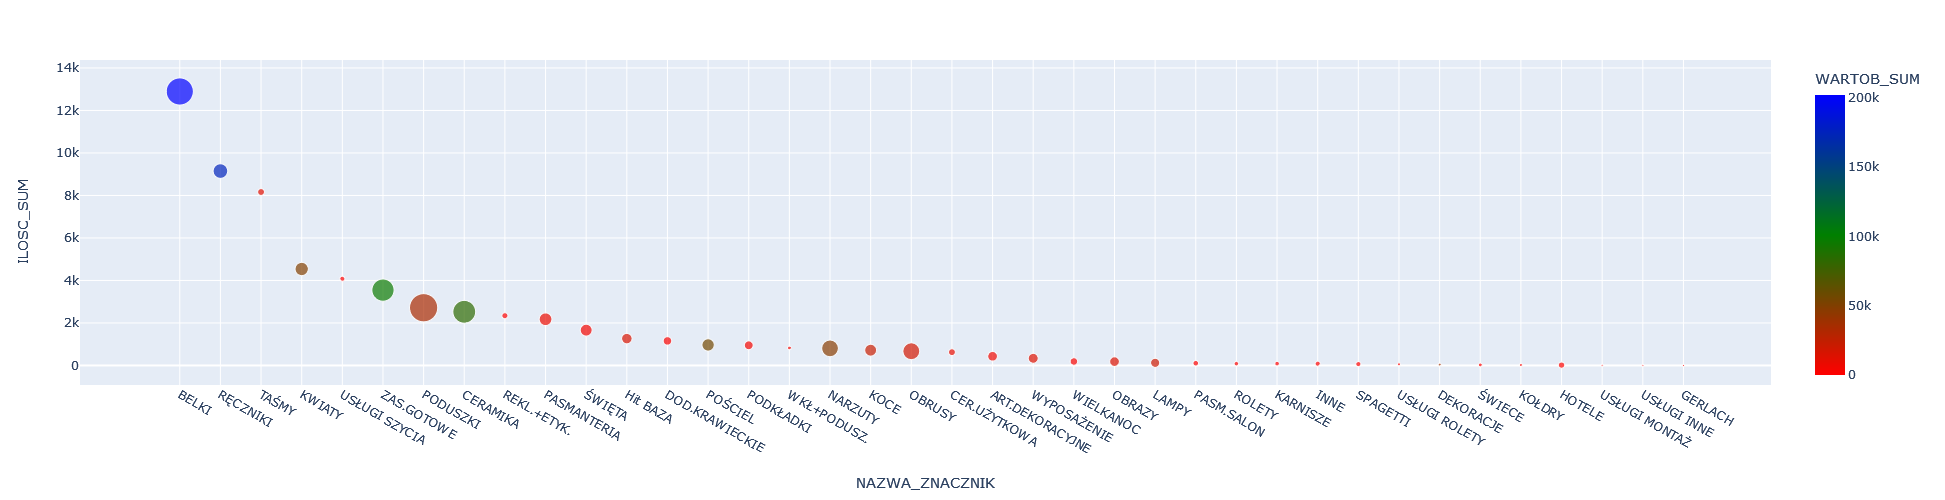

In [18]:
px.scatter(df_sell.loc[df_sell['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'WARTOB_SUM':'sum',
                                                                                  'ILOSC_SUM':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='ILOSC_SUM', ascending=False),
           x='NAZWA_ZNACZNIK',
           color='WARTOB_SUM',
           y='ILOSC_SUM',
          color_continuous_scale=['red', 'green','blue'],
          size='TRZY',
          height=500)

In [13]:
df_sell.groupby('ANALIT01').agg({'WARTOB_SUM':'sum'}).sort_values(by='WARTOB_SUM', ascending=False)

WARTOB_SUM
ANALIT01              
00        5.330691e+07
SI        1.207249e+07
          9.910097e+06
FR        8.717820e+06
SW        8.671142e+06
SF        2.685968e+06
OU        9.427402e+05
FE        4.100300e+02

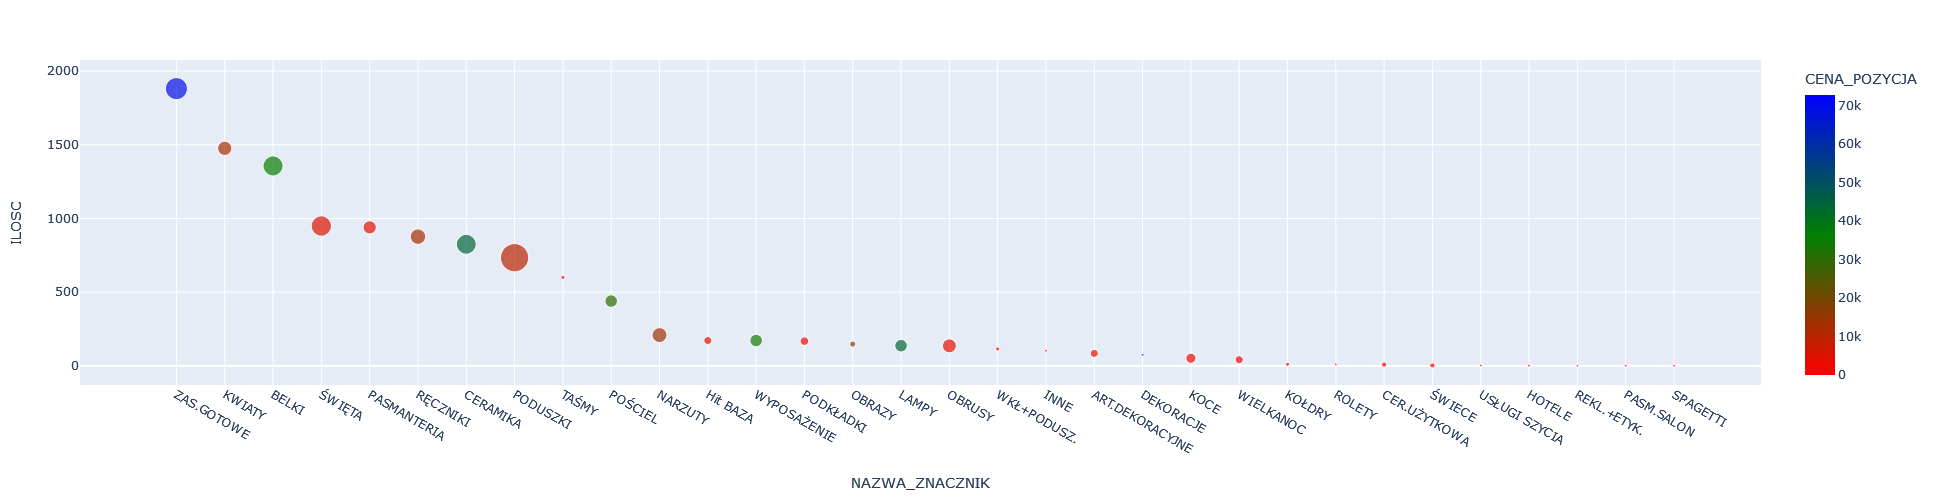

In [19]:
px.scatter(df_fi.loc[df_fi['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
                                                                                  'ILOSC':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='ILOSC', ascending=False),
           x='NAZWA_ZNACZNIK',
           color='CENA_POZYCJA',
           y='ILOSC',
          color_continuous_scale=['red', 'green','blue'],
          size='TRZY',
          height=500)

<AxesSubplot:xlabel='NAZWA_ZNACZNIK'>

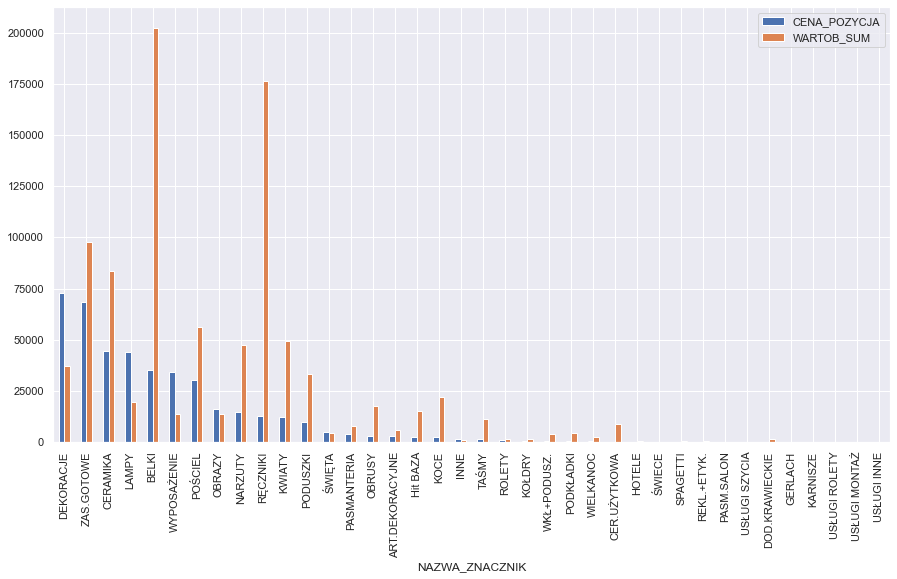

In [19]:
df_fi.loc[df_fi['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
                                                                                  'ILOSC':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='CENA_POZYCJA', ascending=False).\
merge(df_sell.loc[df_sell['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'WARTOB_SUM':'sum',
                                                                                  'ILOSC_SUM':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='WARTOB_SUM', ascending=False),
how='outer',
on='NAZWA_ZNACZNIK')[['NAZWA_ZNACZNIK','CENA_POZYCJA','WARTOB_SUM']].set_index('NAZWA_ZNACZNIK').plot(kind='bar')

In [15]:
df_fi.loc[df_fi['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
                                                                                  'ILOSC':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='CENA_POZYCJA', ascending=False).\
merge(df_sell.loc[df_sell['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'WARTOB_SUM':'sum',
                                                                                  'ILOSC_SUM':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='WARTOB_SUM', ascending=False),
how='outer',
on='NAZWA_ZNACZNIK')

NAZWA_ZNACZNIK  CENA_POZYCJA    ILOSC  TRZY_x  WARTOB_SUM     ILOSC_SUM  \
0         DEKORACJE  72649.383093    75.41     1.0    37148.62     42.000000   
1        ZAS.GOTOWE  68623.581900  1885.00    52.0    97579.46   3569.650000   
2          CERAMIKA  44314.366200   826.00    42.0    83695.54   2538.000000   
3             LAMPY  44109.189900   138.00    17.0    19635.24    123.000000   
4             BELKI  35380.904613  1356.51    43.0   202318.45  12920.991566   
5       WYPOSAŻENIE  34194.922500   172.00    17.0    13546.70    340.000000   
6           POŚCIEL  30425.169300   440.00    17.0    56063.72    973.000000   
7            OBRAZY  16221.904200   148.00     4.0    13856.35    184.000000   
8           NARZUTY  14699.701200   217.00    24.0    47618.77    811.000000   
9          RĘCZNIKI  12810.548400   879.00    26.0   176142.85   9197.000000   
10           KWIATY  12083.175600  1476.00    22.0    49539.75   4562.000000   
11         PODUSZKI   9721.059000   734.00    85.0    33258.60   2738.000000   
12           ŚWIĘTA   4865.351100   949.00    44.0     4240.05   1662.000000   
13      PASMANTERIA   3910.834200   939.84    19.0     7635.23   2190.450000   
14           OBRUSY   3094.065000   136.00    21.0    17654.00    677.000000   
15  ART.DEKORACYJNE   3008.235600    85.00     7.0     5823.06    448.000000   
16         Hit BAZA   2666.517000   177.30     7.0    14963.32   1264.683333   
17             KOCE   2491.537200    52.00    11.0    22034.31    724.000000   
18             INNE   1674.768000   104.00     1.0      802.90     88.200000   
19            TAŚMY   1255.778340   600.45     2.0    11022.91   8164.070000   
20           ROLETY    894.726600    10.00     1.0     1595.59     87.400000   
21           KOŁDRY    738.811800    11.00     2.0     1283.33     21.000000   
22      WKŁ+PODUSZ.    703.842900   115.00     2.0     4010.46    838.000000   
23        PODKŁADKI    597.792300   168.00     8.0     4272.00    958.000000   
24        WIELKANOC    372.013500    42.00     7.0     2364.14    188.000000   
25     CER.UŻYTKOWA    242.002500     9.00     3.0     8721.39    626.000000   
26           HOTELE     52.914600     2.00     1.0      467.16     17.500000   
27           ŚWIECE     39.901200     3.00     3.0      153.09     26.000000   
28         SPAGETTI     38.745000     1.00     1.0      425.88     66.000000   
29      REKL.+ETYK.      7.552200     1.00     1.0      285.33   2354.000000   
30       PASM.SALON      0.000000     1.00     1.0      266.62    121.070000   
31    USŁUGI SZYCIA      0.000000     2.00     1.0        0.00   4098.005000   
32   DOD.KRAWIECKIE           NaN      NaN     NaN     1570.78   1192.616140   
33          GERLACH           NaN      NaN     NaN      139.07      2.000000   
34         KARNISZE           NaN      NaN     NaN       56.53     87.000000   
35    USŁUGI ROLETY           NaN      NaN     NaN        0.00     57.960000   
36    USŁUGI MONTAŻ           NaN      NaN     NaN        0.00      8.000000   
37      USŁUGI INNE           NaN      NaN     NaN        0.00      5.000000   

    TRZY_y  
0        2  
1       93  
2       98  
3       16  
4      139  
5       20  
6       30  
7       18  
8       53  
9       41  
10      34  
11     150  
12      27  
13      31  
14      54  
15      18  
16      21  
17      27  
18       5  
19       9  
20       4  
21       2  
22       3  
23      16  
24      11  
25       9  
26       8  
27       3  
28       5  
29       7  
30       6  
31       5  
32      14  
33       1  
34       4  
35       2  
36       1  
37       1

# korekty SI

In [74]:
df_sell_total=func_sell('hurtbi_fakty_sprz_22_2')
#df_sell_total=df_sell_total.loc[df_sell_total['TYP_DOK'].str.contains('F')]
df_sell_total=df_sell_total.loc[df_sell_total['Z_DNIA']<np.datetime64('2022-07-01')]
df_sell_total=func_slownik_nazwa_rodzaj(df_sell_total)
df_sell_total=func_przeliczenie_belek(df_sell_total, 'ILOSC_SUM')
df_sell_total['WARTSB_SUM_BRUTTO_SALON_ABS']=abs(df_sell_total['WARTSB_SUM_BRUTTO_SALON'])

In [75]:
df_sell_total['czy_korekta']=df_sell_total['TYP_DOK'].apply(lambda x: 'tak' if x[0]=='K' else 'nie')

<AxesSubplot:xlabel='czy_korekta'>

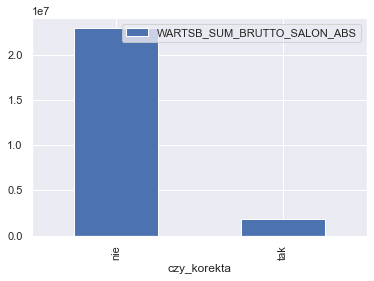

In [78]:
df_sell_total.loc[df_sell_total['FILIA']=='SI'].groupby('czy_korekta').agg({'WARTSB_SUM_BRUTTO_SALON_ABS':'sum'}).plot(kind='bar')


In [93]:
def func_pivot(df,
              col,
              ind,
              val):
    df=pd.pivot(df,
                    index=ind,
                    columns=col,
                    values=val)
    for i in df.columns:
        df=df.rename(columns={i:val+'__'+col+'_'+i})
    return df.reset_index()

In [129]:
def func___(name):
    df_sell_korekty=func_pivot(df_sell_total.loc[df_sell_total['NAZWA_ZNACZNIK']!='INNE'].loc[df_sell_total['FILIA']=='SI'].\
                                           groupby(name+['czy_korekta']).agg({'WARTSB_SUM_BRUTTO_SALON_ABS':'sum'}).reset_index(),
                                  'czy_korekta',
                                  name,
                                  'WARTSB_SUM_BRUTTO_SALON_ABS')

    df_sell_korekty['procent_zwrotow']=df_sell_korekty['WARTSB_SUM_BRUTTO_SALON_ABS__czy_korekta_tak']/df_sell_korekty['WARTSB_SUM_BRUTTO_SALON_ABS__czy_korekta_nie']*100
    #display(df_sell_korekty)
    # fig=px.bar(df_sell_korekty.sort_values(by='WARTSB_SUM_BRUTTO_SALON_ABS__czy_korekta_tak'),
    #       x=name,
    #       color='procent_zwrotow',
    #       y='WARTSB_SUM_BRUTTO_SALON_ABS__czy_korekta_tak',
    #       color_continuous_scale=['red','green','blue'],
    #           height=800)
    fig = px.treemap(df_sell_korekty, path=name, values='WARTSB_SUM_BRUTTO_SALON_ABS__czy_korekta_tak', hover_data=['procent_zwrotow'],
                        height=600)
    fig.data[0].textinfo = "label+value+percent parent+percent entry+percent root"
    fig.show()
    fig.write_html('duze_drzewo_zwroty_si.html')
    return df_sell_korekty

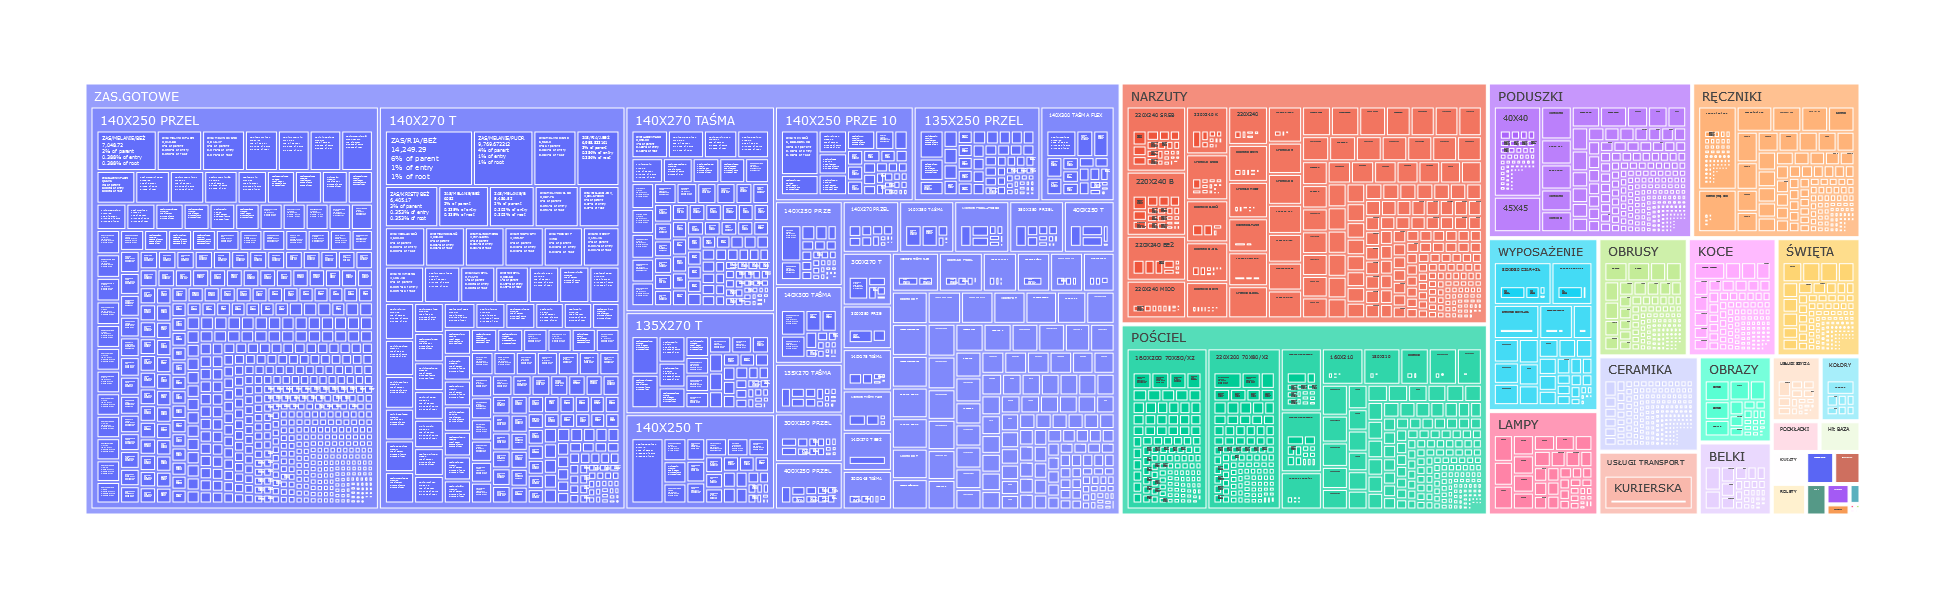

In [130]:
df_sell_korekty=func___(['NAZWA_ZNACZNIK','RODZAJ','NAZWA'])

In [125]:
df_sell_total.loc[df_sell_total['NAZWA_ZNACZNIK']!='INNE'].loc[df_sell_total['FILIA']=='SI'].loc[df_sell_total['czy_korekta']=='tak']['WARTSB_SUM_BRUTTO_SALON_ABS'].sum()

1814549.5245034187

In [126]:
7048/1814549*100

0.3884160747381305

In [131]:
df_sell_korekty

czy_korekta   NAZWA_ZNACZNIK           RODZAJ             NAZWA  \
0            ART.DEKORACYJNE                1   ZESTAW UPOMIN.1   
1            ART.DEKORACYJNE                2   ZESTAW UPOMIN.2   
2            ART.DEKORACYJNE  21X14X10CM KREM    K/KOR/NESS/3/K   
3            ART.DEKORACYJNE                3   ZESTAW UPOMIN.3   
4            ART.DEKORACYJNE          32RDX10        K/HELEN/03   
...                      ...              ...               ...   
16207                 ŚWIĘTA     INT/GH32/220   SW/EKSP.CHOINKA   
16208                 ŚWIĘTA     INT/GH42/220   SW/EKSP.CHOINKA   
16209                 ŚWIĘTA              X12  SW/ORCHID/1/BRĄZ   
16210                 ŚWIĘTA       X12   SZAM    SW/G/ELLE/SZAM   
16211                 ŚWIĘTA  X6         SZAM     SW/B/JANE/1-3   

czy_korekta  WARTSB_SUM_BRUTTO_SALON_ABS__czy_korekta_nie  \
0                                                 5640.02   
1                                                11629.18   
2                                                   18.45   
3                                                  844.56   
4                                                  494.25   
...                                                   ...   
16207                                                 NaN   
16208                                                 NaN   
16209                                               50.96   
16210                                               61.60   
16211                                              234.66   

czy_korekta  WARTSB_SUM_BRUTTO_SALON_ABS__czy_korekta_tak  procent_zwrotow  
0                                                     NaN              NaN  
1                                                    1.54         0.013243  
2                                                     NaN              NaN  
3                                                     NaN              NaN  
4                                                     NaN              NaN  
...                                                   ...              ...  
16207                                              305.10              NaN  
16208                                              419.00              NaN  
16209                                               50.96       100.000000  
16210                                                 NaN              NaN  
16211                                               33.18        14.139606  

[16212 rows x 6 columns]

In [79]:
df_sell_total.loc[df_sell_total['FILIA']=='SI'].groupby(['NAZWA_ZNACZNIK','czy_korekta']).agg({'WARTSB_SUM_BRUTTO_SALON_ABS':'sum'})

WARTSB_SUM_BRUTTO_SALON_ABS
NAZWA_ZNACZNIK  czy_korekta                             
ART.DEKORACYJNE nie                         4.951948e+04
                tak                         5.126900e+02
BELKI           nie                         1.588542e+06
                tak                         1.257693e+04
CER.UŻYTKOWA    nie                         1.608365e+04
...                                                  ...
ZAS.GOTOWE      tak                         1.058603e+06
ŚWIECE          nie                         7.288130e+03
                tak                         1.590000e+01
ŚWIĘTA          nie                         1.435594e+05
                tak                         2.340562e+04

[71 rows x 1 columns]

# szac

In [21]:
print(df_fi['Z_DNIA'].min())
print(df_fi['Z_DNIA'].max())

2022-01-03 00:00:00
2022-06-30 00:00:00


In [19]:
print(df_szac['Z_DNIA'].min())
print(df_szac['Z_DNIA'].max())

2022-01-03 00:00:00
2022-06-30 00:00:00


In [29]:
df_szac.loc[df_szac['NAZWA2'].str[:2]=='F/'].loc[df_szac['ILOSC1']==0].loc[df_szac['ILOSC2']>0].\
groupby(['NAZWA_ZNACZNIK']).agg({'ILOSC2':['sum','count']})#.sort_values('ILOSC2', ascending=False)

ILOSC2      
                     sum count
NAZWA_ZNACZNIK                
ART.DEKORACYJNE    50.00    23
BELKI            1511.07   239
CER.UŻYTKOWA        8.00     6
CERAMIKA          223.00   185
HOTELE              2.00     1
Hit BAZA          158.70    20
KOCE               50.00    50
KOŁDRY              6.00     4
KWIATY           1276.00   247
LAMPY              44.00    35
NARZUTY           208.00   198
OBRAZY             53.00    53
OBRUSY            117.00    92
PASM.SALON          1.00     1
PASMANTERIA       306.84    60
PODKŁADKI         124.00    61
PODUSZKI          708.00   491
POŚCIEL           413.00   371
ROLETY             10.00    10
RĘCZNIKI          699.00   424
SPAGETTI            1.00     1
TAŚMY             405.00     4
WIELKANOC          38.00    20
WKŁ+PODUSZ.       216.00    17
WYPOSAŻENIE        67.00    61
ZAS.GOTOWE       1661.00  1254
ŚWIECE              3.00     3
ŚWIĘTA            898.00   166

# inne

In [15]:
# df_szac_bez_duplikatow=pd.DataFrame()
# brak_zmiany_ceny=0
# zmiana_ceny=0
# ind_zmiana_ceny=[]
# for fakt in tqdm(df_szac['FAKTURA'].unique()):
#     for nazwa in df_szac.loc[df_szac['FAKTURA']==fakt]['NAZWA1_BEZ_F'].unique():
#         if len(df_szac.loc[df_szac['FAKTURA']==fakt].loc[df_szac['NAZWA1_BEZ_F']==nazwa])>1:
#             ind=df_szac.loc[df_szac['FAKTURA']==fakt].loc[df_szac['NAZWA1_BEZ_F']==nazwa].index
#             if df_szac.loc[ind[0], 'CENA_Z1']!=df_szac.loc[ind[1], 'CENA_Z2']:
#                 zmiana_ceny+=1
#                 ind_zmiana_ceny=np.append(ind_zmiana_ceny, ind)
#             else: brak_zmiany_ceny+=1
#         else: continue


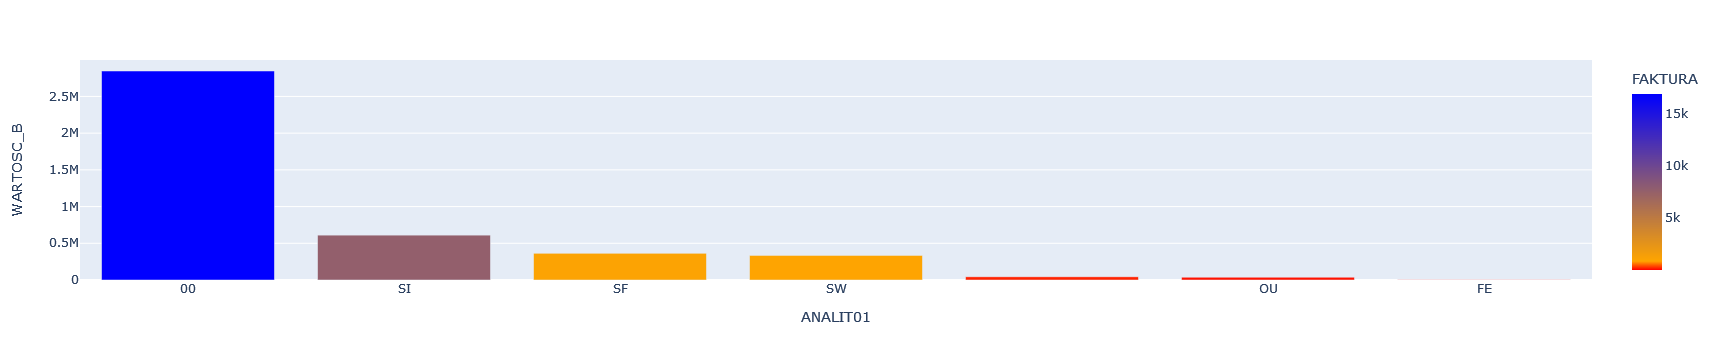

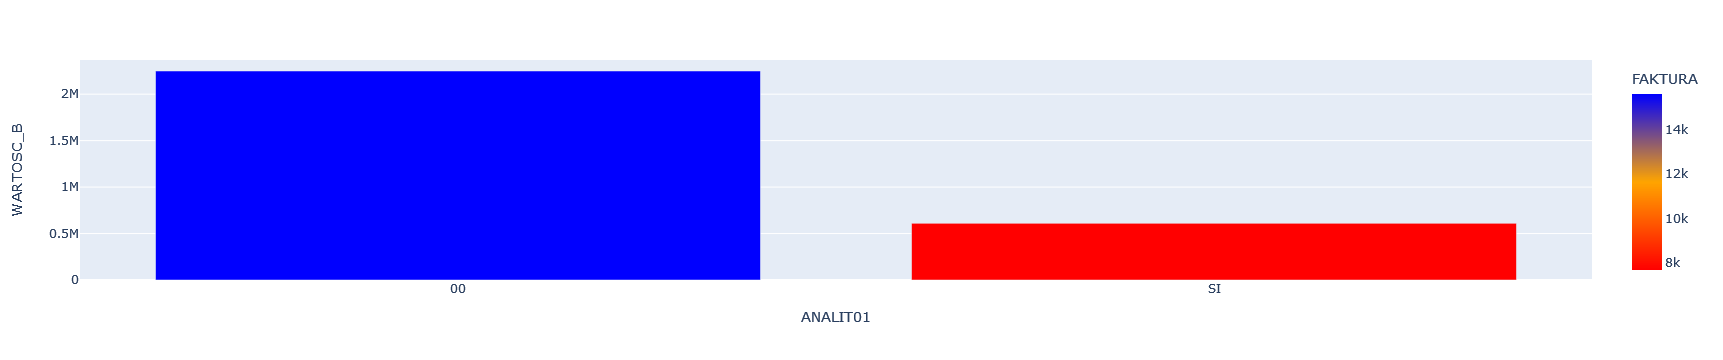

In [9]:
fig=px.bar(df_ff.groupby('ANALIT01').agg({'FAKTURA':'nunique',
                                               'WARTOSC_B':'sum'}).sort_values(by='WARTOSC_B', ascending=False).reset_index(),
           x='ANALIT01',
           y='WARTOSC_B',
           color='FAKTURA',
          color_continuous_scale=[[0,'red'],[0.05,'orange'],[1,'blue']])
fig.show()
fig=px.bar(df_ff.loc[df_ff['FAKTURA_FK']!=' '].groupby('ANALIT01').agg({'FAKTURA':'nunique',
                                                                           'WARTOSC_B':'sum'}).sort_values(by='WARTOSC_B', ascending=False).reset_index(),
           x='ANALIT01',
           y='WARTOSC_B',
           color='FAKTURA',
          color_continuous_scale=[[0,'red'],[0.5,'orange'],[1,'blue']])
fig.show()

In [28]:
100-2.25/2.85*100

21.05263157894737

In [19]:
df_ff['FAKTURA_FK']

0                    
1                    
2                    
3                    
4                    
             ...     
30651                
30652    KVSI00048042
30653    KV0000128896
30654    KV0000128912
30655                
Name: FAKTURA_FK, Length: 26878, dtype: object

In [10]:
df_ff.groupby('ANALIT01').agg(faktura_ff=('FAKTURA','nunique'),
                                wartosc_b_ff=('WARTOSC_B','sum')).sort_values(by='wartosc_b_ff', ascending=False).merge(
df_fi.groupby('ANALIT01').agg(faktura_fi=('FAKTURA','nunique'),
                                wartosc_b_fi=('CENA_POZYCJA','sum')),
how='outer',
left_index=True, right_index=True)

faktura_ff  wartosc_b_ff  faktura_fi  wartosc_b_fi
ANALIT01                                                    
               190.0      43045.31       363.0  1.503429e+05
00           16914.0    2846325.18     17215.0  7.881812e+06
FE              17.0       2178.96       577.0  1.782596e+05
LI               NaN           NaN      1829.0  2.361223e+05
OU             107.0      38359.28      3112.0  4.218893e+05
SF            1057.0     364917.56        24.0  9.515354e+03
SI            7675.0     611520.78         NaN           NaN
SW             918.0     334284.56        32.0  2.302440e+04

In [11]:
display(df_ff.agg(faktura_ff=('FAKTURA','nunique'),
                                wartosc_b_ff=('WARTOSC_B','sum')))
display(df_fi.agg(faktura_fi=('FAKTURA','nunique'),
                                wartosc_b_fi=('CENA_POZYCJA','sum')))
# how='outer',
# left_index=True, right_index=True)

FAKTURA   WARTOSC_B
faktura_ff    26878.0         NaN
wartosc_b_ff      NaN  4240631.63

FAKTURA  CENA_POZYCJA
faktura_fi    23152.0           NaN
wartosc_b_fi      NaN  8.900965e+06

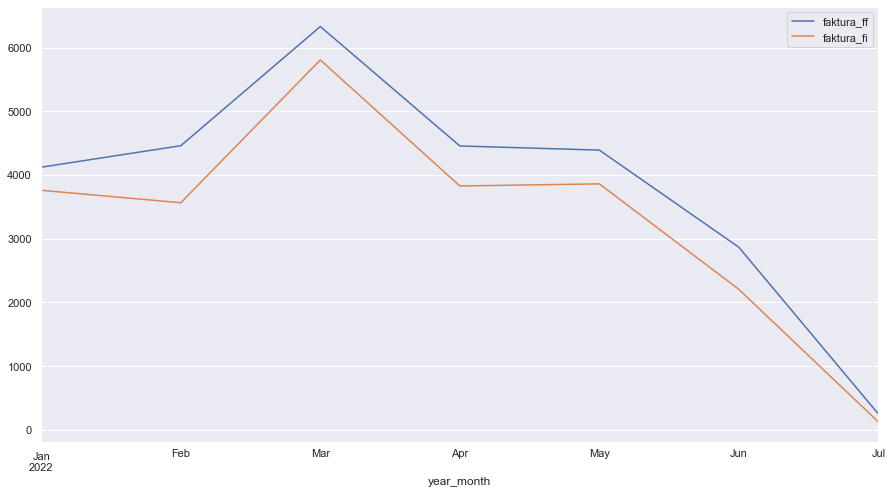

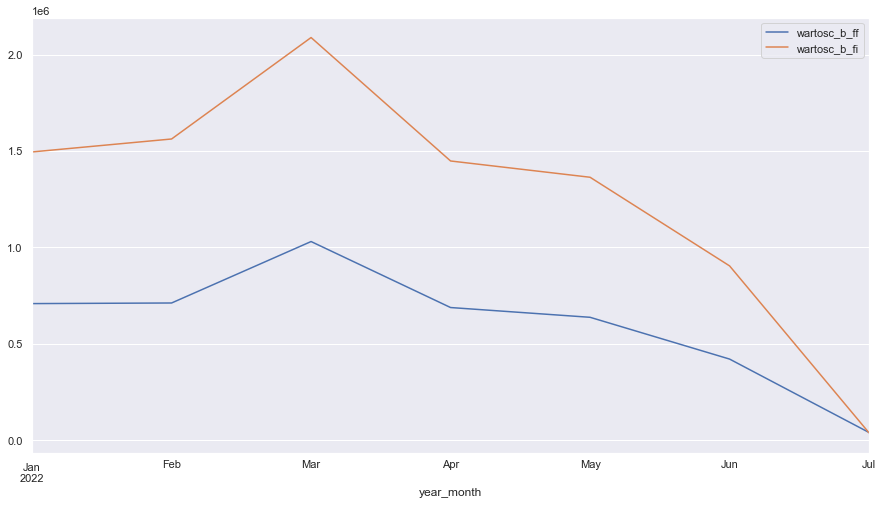

In [14]:
df_ff.groupby('year_month').agg(faktura_ff=('FAKTURA','nunique')).merge(
df_fi.groupby('year_month').agg(faktura_fi=('FAKTURA','nunique')),
how='outer',
left_index=True, right_index=True).plot()
plt.show()
df_ff.groupby('year_month').agg(wartosc_b_ff=('WARTOSC_B','sum')).merge(
df_fi.groupby('year_month').agg(wartosc_b_fi=('CENA_POZYCJA','sum')),
how='outer',
left_index=True, right_index=True).plot()
plt.show()

In [49]:
df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N']
df_slownik=func_add_znacznik(df_slownik)

In [47]:
df_slownik['KOD_PRODUC'].nunique()

927

In [48]:
df_slownik.groupby('TRZY').agg({'KOD_TEMA':'nunique',
                               'KOD_PRODUC':'unique'}).sort_values(by='KOD_TEMA', ascending=False)#.head(50)

KOD_TEMA KOD_PRODUC
TRZY                     
         44911        [ ]
EUR       6096        [ ]
BIS       4744        [ ]
XMH       4115        [ ]
QIN       3160        [ ]
...        ...        ...
U08          1        [ ]
AJ           1        [ ]
L25          1        [ ]
LA           1        [ ]
STI          1        [ ]

[1956 rows x 2 columns]

In [38]:
df_slownik.loc[df_slownik['TRZY']=='EUR']

RECNO IS_DELETED             NAZWA              RODZAJ  KOD_TEMA  \
158        202          N     WYROBY GOTOWE                         27037   
222        284          N     ZA/AXEL/B+BEŻ      140X250 P/9166     34441   
223        285          N    ZA/AXEL/B+CZER      140X250 P/9166     34442   
297        388          N   FIRANA/ALICJA/K                   #     67180   
1171    183107          N        FIR/LUCY/B       300X160 PRZEL    338504   
...        ...        ...               ...                 ...       ...   
229903  255122          N    ZAS/CHARLOTTE1  GRAN 140X250 PRZEL    416054   
229904  255123          N    ZAS/CHARLOTTE1  MIÓD 140X250 PRZEL    416055   
229905  255124          N    ZAS/CHARLOTTE1  STAL 140X250 PRZEL    416056   
229917  255195          N          WORECZEK            60X60 CM    416127   
230056  256202          N  F/TC/SEVILLE/Z/4   140X270 TAŚMA BEŻ    417133   

        KOD_TEMA_W  KOD_TEMA_K FUN_KW  ZNACZNIK  NR_ZAKL_P CENA_Z PCENA_Z  \
158              0           0               99          0   2,78       0   
222              0           0                3          0  16,67       0   
223              0           0                3          0  16,67       0   
297              0           0                3          0   5,53       0   
1171             0           0                3          0   54,9   36,56   
...            ...         ...    ...       ...        ...    ...     ...   
229903           0           0                3          0      0       0   
229904           0           0                3          0      0       0   
229905           0           0                3          0  35,62       0   
229917           0           0               99          0   2,18       0   
230056           0           0                3          0  62,78   62,85   

          CENA  CENA_D  GRUPA PODGRUPA  VAT_P  VAT_R  VAT_N SWW    PKWIU  \
158          5    11,9     99     0204     23     23      0                
222         30    83,9      3     0115     23     23      0                
223         30    83,9      3     0115     23     23      0                
297       9,96    22,9      3     0330     23     23      0                
1171      35,9    76,9      3     0321     23     23      0      O278759   
...        ...     ...    ...      ...    ...    ...    ...  ..      ...   
229903  117,89       0      3     0111     23     23      0                
229904  117,89       0      3     0111     23     23      0                
229905  117,89       0      3     0111     23     23      0                
229917    6,58       0     99       02     23     23      0                
230056  112,16  137,95      3     0189     23     23      0                

       OST_PRZ      OST_FAKT  MIN_ZAM  IL_MIN  IL_MAX DZIENNY_R DZIENNY_RC  \
158          0                      0       0       0         0          5   
222          0                      0       0       0        30         30   
223          0                      0       0       0        30         30   
297          0                      0       0       0      9,96       9,96   
1171        55  ZFSC00008460        0       0       0         0          0   
...        ...           ...      ...     ...     ...       ...        ...   
229903       0                      0       0       0         0          0   
229904       0                      0       0       0         0          0   
229905       8  ZFSC00014139        0       0       0         0          0   
229917     100  ZFSC00014289        0       0       0         0          0   
230056       0                      0       0       0         0          0   

        W_ZGRZEWCE SZTUK_KART  W_WARSTWIE  W_PALECIE  SUMA_DNI  ILOSC ZALECAM  \
158              0          0           0          0         0      0       0   
222              0          0           0          0         0      0       0   
223              0          0           0          0         0    

# polaczenie z baza (potrzebne haslo do testow)

In [23]:
import cx_Oracle
#cx_Oracle.init_oracle_client(lib_dir=r"C:\oracle_python\instantclient_19_9")
try:
    host = '192.168.0.206'
    port = 1521
    SID = 'orcl'
    
    dsn = cx_Oracle.makedsn(host, port, SID)
    
    connection = cx_Oracle.connect(user="EF_KG",
                                  password='HgmD5U$CcC',
                                  dsn=dsn,
                                   encoding="UTF-8")

    # show the version of the Oracle Database
    print(connection.version)
    
    query = """SELECT * 
           FROM HURT00.GRUP_RCP"""
    df_ora = pd.read_sql(query, con=connection)

except cx_Oracle.Error as error:
    print(error)
finally:
    # release the connection
    if connection:
        connection.close()


11.2.0.4.0


In [21]:
connection

<cx_Oracle.Connection to EF_KG@(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=192.168.0.206)(PORT=1521))(CONNECT_DATA=(SID=orcl)))>

In [24]:
df_ora

RECNO IS_DELETED KOD_GR_RCP               GR_OPIS FILIA
0      27          N          K               KOREKTY    00
1      28          N        P I    PRACOWNIA I ZMIANA    00
2      29          N        KUP                KUPONY    00
3      30          N         PR              PRÓBNIKI    00
4      35          N         C5              SALON C5    C5
..    ...        ...        ...                   ...   ...
82     83          N       A-L4     DŁUGA NIEOBECNOŚĆ    00
83     88          N      A-ZAR  ADMINISTRACJA ZARZĄD    00
84      5          N       ZI Ś       ZMIANA I ŚWIĘTA    00
85     33          N          M   MONTAŻYŚCI/KIEROWCY    00
86     87          N      SZW-I     SZWALNIA INTERNET    00

[87 rows x 5 columns]